## Set up notebook

In [1]:
# Import packages
import numpy as np
import os
import pandas as pd
import random as rm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from math import gamma, exp, log, log10, pi
import seaborn as sns
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

In [2]:
# Set up matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator
import mpl_scatter_density
%matplotlib inline
params = {'legend.fontsize': 22,
          'figure.figsize': (12, 8),
         'axes.labelsize': 22,
         'axes.titlesize': 24,
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
plt.rcParams.update(params)

In [3]:
# "Viridis-like" colormap with white background
white_viridis = mpl.colors.LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'), ], N=256)

## Import data

In [4]:
data = Table.read('../Data_tabs/CosmosDeep/single_sersic/sepp_sersic_20231220T101523_out.fits', format='fits')
d_cat = Table.read('../Data_tabs/CosmosDeep/single_sersic/EUC_MER_FINAL-CAT_TILE101545697-B2CED4_20231222T025656.220453Z_00.00.fits', format='fits')
d_morph = Table.read('../Data_tabs/CosmosDeep/single_sersic/EUC_MER_FINAL-MORPH-CAT_TILE101545697-9C3611_20231222T025655.428526Z_00.00.fits', format='fits')

In [5]:
df_cat = d_cat.to_pandas()
df_morph = d_morph.to_pandas()

In [6]:
df_cat.shape, df_morph.shape

((59545, 337), (59545, 94))

In [7]:
data

<Table length=59545>
fmf_reduced_chi_2  fmf_iterations ... assoc_match      assoc_values    
                                  ...                                  
     float64           int32      ...     bool          float32[7]     
------------------ -------------- ... ----------- ---------------------
3.3642728328704834             49 ...        True   0.054602746 .. -1.0
32.898956298828125             79 ...        True   0.082697414 .. -1.0
0.8301388025283813             71 ...        True   0.023288423 .. -1.0
 2.765429735183716             94 ...        True     0.0742751 .. -1.0
7.6844353675842285            103 ...        True     0.0629343 .. -1.0
2.6954517364501953            124 ...        True    0.06217588 .. -1.0
4.2399373054504395            105 ...        True    0.21349473 .. -1.0
120.50894927978516            121 ...        True    0.16105834 .. -1.0
0.5694687366485596             61 ...        True    0.10960754 .. -1.0
               ...            ... ...         ...                   ...
  165.880615234375            196 ...        True    20.63878 .. 7035.0
 433.3358459472656            127 ...        True   23.916021 .. 7035.0
     9607.66015625            103 ...        True    6.668036 .. 7035.0
193.89028930664062            213 ...        True    4606.781 .. 7035.0
   14222.060546875            166 ...        True    9.137951 .. 7035.0
  12218.4404296875            159 ...        True   2.1141772 .. 7035.0
 3530.715576171875            164 ...        True   321.98505 .. 7035.0
 8.577545166015625            139 ...        True   37.403305 .. 7035.0
18.764741897583008            225 ...        True 0.020949133 .. 7035.0
 77.94699096679688            140 ...        True    14.90633 .. 7035.0

In [8]:
df_morph.columns.values

array(['OBJECT_ID', 'CONCENTRATION', 'CONCENTRATION_ERR', 'ASYMMETRY',
       'ASYMMETRY_ERR', 'SMOOTHNESS', 'SMOOTHNESS_ERR', 'GINI',
       'GINI_ERR', 'MOMENT_20', 'MOMENT_20_ERR', 'SERSIC_REDUCED_CHI2',
       'SERSIC_ITERATIONS', 'SERSIC_FLAGS', 'SERSIC_DURATION',
       'SERSIC_SERSIC_RADIUS', 'SERSIC_SERSIC_RADIUS_ERR',
       'SERSIC_SERSIC_AXIS_RATIO', 'SERSIC_SERSIC_AXIS_RATIO_ERR',
       'SERSIC_SERSIC_INDEX', 'SERSIC_SERSIC_INDEX_ERR', 'SERSIC_ANGLE',
       'SERSIC_ANGLE_ERR', 'DISK_SERSIC_REDUCED_CHI2',
       'DISK_SERSIC_ITERATIONS', 'DISK_SERSIC_FLAGS',
       'DISK_SERSIC_DURATION', 'DISK_SERSIC_SERSIC_RADIUS',
       'DISK_SERSIC_SERSIC_RADIUS_ERR', 'DISK_SERSIC_SERSIC_AXIS_RATIO',
       'DISK_SERSIC_SERSIC_AXIS_RATIO_ERR', 'DISK_SERSIC_SERSIC_INDEX',
       'DISK_SERSIC_SERSIC_INDEX_ERR', 'DISK_SERSIC_DISK_RADIUS',
       'DISK_SERSIC_DISK_RADIUS_ERR', 'DISK_SERSIC_DISK_AXIS_RATIO',
       'DISK_SERSIC_DISK_AXIS_RATIO_ERR', 'DISK_SERSIC_ANGLE',
       'DISK_SERSIC

In [9]:
df = df_cat.merge(df_morph, on='OBJECT_ID', how='inner')
df

OBJECT_ID  RIGHT_ASCENSION  DECLINATION  \
0      1500022937023752696       150.002294     2.375270   
1      1500894816023745928       150.089482     2.374593   
2      1501991414023748952       150.199141     2.374895   
3      1500347924023741132       150.034792     2.374113   
4      1500679181023742240       150.067918     2.374224   
...                    ...              ...          ...   
59540  1502569535025998772       150.256954     2.599877   
59541  1502176237026095667       150.217624     2.609567   
59542  1502200932026216252       150.220093     2.621625   
59543  1500885141026053147       150.088514     2.605315   
59544  1500919321026236627       150.091932     2.623663   

       RIGHT_ASCENSION_PSF_FITTING  DECLINATION_PSF_FITTING  \
0                              NaN                      NaN   
1                              NaN                      NaN   
2                              NaN                      NaN   
3                              NaN                      NaN   
4                              NaN                      NaN   
...                            ...                      ...   
59540                          NaN                      NaN   
59541                          NaN                      NaN   
59542                          NaN                      NaN   
59543                          NaN                      NaN   
59544                          NaN                      NaN   

       SEGMENTATION_MAP_ID  VIS_DET  FLUX_VIS_APER  FLUX_Y_APER  FLUX_J_APER  \
0          101545697002095        1       0.154262     0.275510     0.311199   
1          101545697002814        1       0.052753     0.355048     0.518383   
2          101545697003569        1       0.073982     0.064631     0.095461   
3          101545697004233        1       0.176066     0.254783     0.381553   
4          101545697004257        1       0.059942     0.073633     0.081947   
...                    ...      ...            ...          ...          ...   
59540      101545697147143        0       0.054694     0.237742     0.227361   
59541      101545697147153        0       0.034179     0.368126     0.346154   
59542      101545697147164        0       0.057393     1.243360     1.029186   
59543      101545697147206        0       0.066503     0.182455     0.190310   
59544      101545697147209        0       0.018868     1.054303     1.071818   

       ...  RING_NO  AGN_YES  AGN_NO  ETG_OR_LTG  T_TYPE  MAJOR_MERGER  \
0      ...      NaN      NaN     NaN         NaN     NaN           NaN   
1      ...      NaN      NaN     NaN         NaN     NaN           NaN   
2      ...      NaN      NaN     NaN         NaN     NaN           NaN   
3      ...      NaN      NaN     NaN         NaN     NaN           NaN   
4      ...      NaN      NaN     NaN         NaN     NaN           NaN   
...    ...      ...      ...     ...         ...     ...           ...   
59540  ...      NaN      NaN     NaN         NaN     NaN           NaN   
59541  ...      NaN      NaN     NaN         NaN     NaN           NaN   
59542  ...      NaN      NaN     NaN         NaN     NaN           NaN   
59543  ...      NaN      NaN     NaN         NaN     NaN           NaN   
59544  ...      NaN      NaN     NaN         NaN     NaN           NaN   

       MAJOR_MERGER_UNCERTAINTY  MAJOR_MERGER_STAGE  \
0                           NaN                <NA>   
1                           NaN                <NA>   
2                           NaN                <NA>   
3                           NaN                <NA>   
4                           NaN                <NA>   
...                         ...                 ...   
59540                       NaN                <NA>   
59541                       NaN                <NA>   
59542                       NaN                <NA>   
59543                       NaN                <NA>   
59544                       NaN                <NA>   

       MAJOR_MERGER_STAGE_PR

In [10]:
df_coords = SkyCoord(df['RIGHT_ASCENSION'].values, df['DECLINATION'].values, unit="deg")
dt_coords = SkyCoord(data['ra'], data['dec'], unit="deg")
idx, sep2d, _ = df_coords.match_to_catalog_sky(dt_coords)
print(len(idx), max(sep2d))

59545 0d00m00s


In [11]:
dtab = data[idx]
dtab['assoc_values'][:,4]

<Column name='assoc_values' dtype='float32' length=59545>
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
   10.0
   11.0
    ...
59533.0
59534.0
59535.0
59536.0
59537.0
59538.0
59539.0
59540.0
59541.0
59542.0
59543.0
59544.0

In [12]:
with np.errstate(divide='ignore'):
    for band in ['VIS', 'Y', 'J', 'H']:
        df['MAG_'+band+'_APER'] = -2.5*np.log10(df['FLUX_'+band+'_APER']/3631) + 30.0 - 15.0
        df['MAGERR_'+band+'_APER'] = 2.5*df['FLUXERR_'+band+'_APER']/(np.log(10)*df['FLUX_'+band+'_APER'])
        df['MAG_'+band+'_SERSIC'] = -2.5*np.log10(df['FLUX_'+band+'_SERSIC']/3631) + 30.0 - 15.0
        df['MAGERR_'+band+'_SERSIC'] = 2.5*df['FLUXERR_'+band+'_SERSIC']/(np.log(10)*df['FLUX_'+band+'_SERSIC'])
        df['MAG_'+band+'_DISK_SERSIC'] = -2.5*np.log10(df['FLUX_'+band+'_DISK_SERSIC']/3631) + 30.0 - 15.0
        df['MAGERR_'+band+'_DISK_SERSIC'] = 2.5*df['FLUXERR_'+band+'_DISK_SERSIC']/(np.log(10)*df['FLUX_'+band+'_DISK_SERSIC'])
        df['FLUX_'+band+'_B'] = df['FLUX_'+band+'_SERSIC']*df['SERSIC_FRACT_'+band+'_DISK_SERSIC']
        df['FLUX_'+band+'_D'] = df['FLUX_'+band+'_SERSIC']*(1 - df['SERSIC_FRACT_'+band+'_DISK_SERSIC'])
        df['FLUXERR_'+band+'_B'] = df['FLUX_'+band+'_B']*np.sqrt(
                                    (df['FLUXERR_'+band+'_SERSIC']/df['FLUX_'+band+'_SERSIC'])**2 +
                                (df['SERSIC_FRACT_'+band+'_DISK_SERSIC_ERR']/df['SERSIC_FRACT_'+band+'_DISK_SERSIC'])**2 )
        df['FLUXERR_'+band+'_D'] = df['FLUX_'+band+'_D']*np.sqrt(
                                    (df['FLUXERR_'+band+'_SERSIC']/df['FLUX_'+band+'_SERSIC'])**2 +
                                (df['SERSIC_FRACT_'+band+'_DISK_SERSIC_ERR']/(1-df['SERSIC_FRACT_'+band+'_DISK_SERSIC']))**2 )
        df['MAG_'+band+'_B'] = -2.5*np.log10(df['FLUX_'+band+'_B']/3631) + 30.0 - 15.0
        df['MAGERR_'+band+'_B'] = 2.5*df['FLUXERR_'+band+'_B']/(np.log(10)*df['FLUX_'+band+'_B'])
        df['MAG_'+band+'_D'] = -2.5*np.log10(df['FLUX_'+band+'_D']/3631) + 30.0 - 5.0
        df['MAGERR_'+band+'_D'] = 2.5*df['FLUXERR_'+band+'_D']/(np.log(10)*df['FLUX_'+band+'_D'])

C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Previous data

In [13]:
col_names = ['ID', 'RA', 'DEC', 'flag', 'use', 'mag', 'dmag', 're', 'dre','n', 'dn', 'q', 'dq', 'pa', 'dpa', 'kron', 'f_F160W_auto','e_F160W_auto', 'f_F160W_tot', 'e_F160W_tot', 'snr','flag_limit_r', 'flag_limit_n', 'flag_deb', 'Mcorr','5_sigma_depth', 'chi', 'chi_nu']
df_hst = pd.read_csv("../Data_tabs/CosmosDeep/hlsp_cosmos-dash_hst_wfc3_cosmos_f160w_v1.3.b_morph-cat.txt",
                     sep=" ", comment="#", names = col_names)
#df_hst.drop(index=df_hst.index[:30], axis=0, inplace=True)
for b in ['_F160W_auto', '_F160W_tot']:
    df_hst['mag'+b] = -2.5*np.log10(df_hst['f'+b]) + 25
    df_hst['mag_err'+b] = 2.5*df_hst['e'+b]/(np.log(10)*df_hst['f'+b])
df_hst.replace([np.inf, -np.inf], np.nan, inplace=True)
df_hst

C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ID         RA       DEC  flag  use   mag  dmag    re   dre     n  \
0            1  150.37265  1.609394     3    0 -99.0 -99.0 -99.0 -99.0 -99.0   
1            2  150.40848  1.607504     3    0 -99.0 -99.0 -99.0 -99.0 -99.0   
2            3  150.40550  1.606911     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
3            4  150.39050  1.604330     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
4            5  150.40334  1.606078     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
...        ...        ...       ...   ...  ...   ...   ...   ...   ...   ...   
262610  262611  149.65096  2.809964     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
262611  262612  149.84779  2.809961     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
262612  262613  149.57330  2.809791     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
262613  262614  149.55443  2.809756     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   
262614  262615  149.44901  2.809952     4    0 -99.0 -99.0 -99.0 -99.0 -99.0   

        ...  flag_limit_n  flag_deb  Mcorr  5_sigma_depth   chi  chi_nu  \
0       ...             0         0    1.0      -0.225442 -99.0   -99.0   
1       ...             0         0    1.0      -0.225442 -99.0   -99.0   
2       ...             0         4    1.0     -99.000000 -99.0   -99.0   
3       ...             0         4    1.0     -99.000000 -99.0   -99.0   
4       ...             0         4    1.0     -99.000000 -99.0   -99.0   
...     ...           ...       ...    ...            ...   ...     ...   
262610  ...             0         4    1.0     -99.000000 -99.0   -99.0   
262611  ...             0         4    1.0     -99.000000 -99.0   -99.0   
262612  ...             0         4    1.0     -99.000000 -99.0   -99.0   
262613  ...             0         4    1.0     -99.000000 -99.0   -99.0   
262614  ...             0         4    1.0     -99.000000 -99.0   -99.0   

        mag_F160W_auto  mag_err_F160W_auto  mag_F160W_tot  mag_err_F160W_tot  
0                  NaN                 NaN            NaN           1.085736  
1                  NaN                 NaN            NaN           1.085736  
2                  NaN            1.085736            NaN           1.085736  
3                  NaN            1.085736            NaN           1.085736  
4                  NaN            1.085736            NaN           1.085736  
...                ...                 ...            ...                ...  
262610             NaN            1.085736            NaN           1.085736  
262611             NaN            1.085736            NaN           1.085736  
262612             NaN            1.085736            NaN           1.085736  
262613             NaN            1.085736            NaN           1.085736  
262614             NaN            1.085736            NaN           1.085736  

[262615 rows x 32 columns]

In [14]:
df_zur = pd.read_table("../Data_tabs/CosmosDeep/cosmos_morph_zurich_1.0.tbl.txt", comment='#', delim_whitespace=True,
                      skiprows=[1,2,3])
cols = df_zur.columns.values
new_cols = [name[:-1] for name in cols[1:]]
df_zur.dropna(axis=1, how='all', inplace = True)
df_zur.rename(columns=dict(zip(cols[:-1], new_cols)), inplace=True)
df_zur

SequentialID          RA       DEC   CAPAK_ID       CAPAK_RA  \
0                1.0  150.796234  1.897984   740771.0     150.796219   
1                2.0  150.794418  1.890546   742119.0     150.794388   
2                3.0  150.794632  1.894150   741503.0     150.794586   
3                4.0  150.793396  1.886970   742662.0     150.793396   
4                5.0  150.789520  1.868036   746072.0     150.789490   
...              ...         ...       ...        ...            ...   
131527      131528.0  149.473496  2.509274  -999999.0 -999999.000000   
131528      131529.0  149.470200  2.494129  -999999.0 -999999.000000   
131529      131530.0  149.449844  2.459868  -999999.0 -999999.000000   
131530      131531.0  149.443909  2.481606  2505387.0     149.444061   
131531      131532.0  149.437439  2.462548  -999999.0 -999999.000000   

            CAPAK_DEC  ACS_MAG_AUTO  ACS_MAGERR_AUTO  ACS_X_IMAGE  \
0            1.897970     20.372242         0.002666  7004.939941   
1            1.890544     22.771563         0.008523  6088.169922   
2            1.894146     23.056213         0.014826  6518.930176   
3            1.886977     23.856871         0.024528  5644.709961   
4            1.868014     23.984516         0.024132  3326.459961   
...               ...           ...              ...          ...   
131527 -999999.000000     23.992823         0.027308  7094.290039   
131528 -999999.000000     23.265909         0.022552  5236.060059   
131529 -999999.000000     23.105940         0.023322   770.030029   
131530       2.481654     23.554340         0.034061  3219.659912   
131531 -999999.000000     23.968447         0.043259   834.200012   

        ACS_Y_IMAGE  ...           PC_1           PC_2           PC_3  \
0       7171.529785  ...      -3.446789       0.027949       0.617810   
1       7107.479981  ...      -0.580690      -3.378245       1.667820   
2       7060.479981  ... -999999.000000 -999999.000000 -999999.000000   
3       7061.020019  ...       0.583980      -1.955296       1.584166   
4       6987.640137  ...      -1.141175      -0.696079      -0.410171   
...             ...  ...            ...            ...            ...   
131527  4226.540039  ... -999999.000000 -999999.000000 -999999.000000   
131528  4145.200195  ... -999999.000000 -999999.000000 -999999.000000   
131529  2439.389893  ...       2.549485      -2.185765       3.936793   
131530  1294.239990  ...       3.163826      -3.975575       3.322199   
131531   918.440002  ... -999999.000000 -999999.000000 -999999.000000   

            TYPE      BULG      IRRE      ELLI  STELLARITY  JUNKFLAG  \
0            2.0       0.0       9.0       1.0         0.0       0.0   
1            3.0       9.0       9.0       0.0         0.0       0.0   
2      -999999.0 -999999.0 -999999.0 -999999.0         0.0       0.0   
3            3.0       9.0       9.0       1.0         0.0       0.0   
4            2.0       1.0       9.0       0.0         0.0       0.0   
...          ...       ...       ...       ...         ...       ...   
131527 -999999.0 -999999.0 -999999.0 -999999.0         0.0       1.0   
131528 -999999.0 -999999.0 -999999.0 -999999.0         0.0       1.0   
131529       9.0       9.0       9.0       0.0         0.0       0.0   
131530       3.0       9.0       9.0       1.0         0.0       0.0   
131531 -999999.0 -999999.0 -999999.0 -999999.0         0.0       1.0   

                                    ACSTile  
0       acs_I_100303+0152_unrot_sci_12.fits  
1       acs_I_100303+0152_unrot_sci_12.fits  
2       acs_I_100303+0152_unrot_sci_12.fits  
3       acs_I_100303+0152_unrot_sci_12.fits  
4       acs_I_100303+0152_unrot_sci_12.fits  
...                                     ...  
131527  acs_I_095751+0228_unrot_sci_12.fits  
131528  acs_I_095751+0228_unrot_sci_12.fits  
131529  acs_I_095751+0228_unrot_sci_12.fits  
131530  acs_I_095751+0228_unrot_sci_12.fits  
131531  acs_I_095751+0228_unrot_sci_12.fits  

[131532 rows x 71 c

In [15]:
df_gri = pd.read_csv("../Data_tabs/CosmosDeep/COSMOS_ACS814_Griggith12.tsv", comment='#', sep=";", low_memory=False)
df_gri.replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_gri = df_gri.iloc[2:,:].reset_index(drop=True)
df_gri.drop(['Imaging'], axis=1, inplace=True)
df_gri = df_gri.astype(float)
df_gri

ObjNo     RAJ2000   DEJ2000     f1   f2      z  umag  gmag  rmag  \
0       20000037.0  150.740907  1.622171  814.0  0.0  1.175   NaN   NaN   NaN   
1       20000038.0  150.734341  1.620476  814.0  0.0  1.009   NaN   NaN   NaN   
2       20017454.0  150.041879  1.631406  814.0  0.0  0.050   NaN   NaN   NaN   
3       20000039.0  150.743176  1.620378  814.0  0.0  1.441   NaN   NaN   NaN   
4       20000040.0  150.736044  1.619598  814.0  0.0  5.694   NaN   NaN   NaN   
...            ...         ...       ...    ...  ...    ...   ...   ...   ...   
304683  20320288.0  149.529901  2.822648  814.0  0.0    NaN   NaN   NaN   NaN   
304684  20320289.0  149.502578  2.826972  814.0  0.0  1.279   NaN   NaN   NaN   
304685  20320290.0  149.527987  2.823521  814.0  0.0    NaN   NaN   NaN   NaN   
304686  20320291.0  149.554072  2.816606  814.0  0.0    NaN   NaN   NaN   NaN   
304687  20320292.0  149.509588  2.825889  814.0  0.0    NaN   NaN   NaN   NaN   

        imag  ...  n.G2  e_n.G2  b/a.G1  e_b/a.G1  b/a.G2  e_b/a.G2  pa.G1  \
0        NaN  ...   NaN     NaN    0.27      0.02     NaN       NaN  45.73   
1        NaN  ...   NaN     NaN    0.29      0.01     NaN       NaN  46.10   
2        NaN  ...   NaN     NaN    0.19      0.00     NaN       NaN -81.79   
3        NaN  ...   NaN     NaN    0.51      0.02     NaN       NaN  21.82   
4        NaN  ...   NaN     NaN    0.89      0.08     NaN       NaN -72.83   
...      ...  ...   ...     ...     ...       ...     ...       ...    ...   
304683   NaN  ...   NaN     NaN    0.63      0.09     NaN       NaN  28.87   
304684   NaN  ...   NaN     NaN    0.30      0.06     NaN       NaN -63.46   
304685   NaN  ...   NaN     NaN    0.25      0.04     NaN       NaN  44.05   
304686   NaN  ...   NaN     NaN    0.37      0.05     NaN       NaN -80.54   
304687   NaN  ...   NaN     NaN    0.35      0.07     NaN       NaN -52.38   

        e_pa.G1  pa.G2  e_pa.G2  
0          1.48    NaN      NaN  
1          1.02    NaN      NaN  
2          0.05    NaN      NaN  
3          1.82    NaN      NaN  
4         41.64    NaN      NaN  
...         ...    ...      ...  
304683     9.78    NaN      NaN  
304684     3.66    NaN      NaN  
304685     2.77    NaN      NaN  
304686     3.58    NaN      NaN  
304687     4.53    NaN      NaN  

[304688 rows x 37 columns]

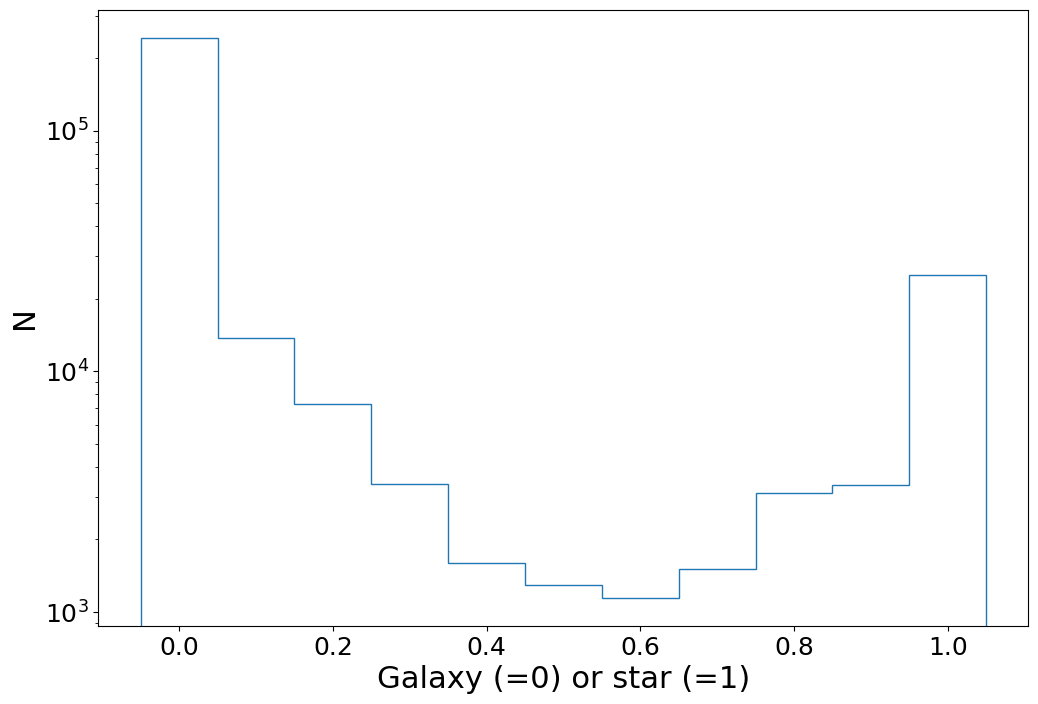

In [16]:
sg1 = df_gri['s/g1'].values.astype(float)
sg2 = df_gri['s/g2'].values.astype(float)
  
plt.hist(sg1, bins = np.linspace(-0.05,1.05,12), histtype='step')
#plt.hist(sg2, bins = np.linspace(-0.05,1.05,12), histtype='step')

plt.yscale('log')
plt.xlabel('Galaxy (=0) or star (=1)')
plt.ylabel('N')
plt.show()

## Compare Euclid Sérsic fits with previous model-fitting results

### Perform cross-match

In [17]:
df_coords = SkyCoord(df['RIGHT_ASCENSION'].values, df['DECLINATION'].values, unit="deg")
coords_hst = SkyCoord(df_hst['RA'], df_hst['DEC'], unit="deg")
coords_zur = SkyCoord(df_zur['RA'], df_zur['DEC'], unit="deg")
coords_gri = SkyCoord(df_gri['RAJ2000'], df_gri['DEJ2000'], unit="deg")
idx_hst, sep2d_hst, _ = df_coords.match_to_catalog_sky(coords_hst)
idx_zur, sep2d_zur, _ = df_coords.match_to_catalog_sky(coords_zur)
idx_gri, sep2d_gri, _ = df_coords.match_to_catalog_sky(coords_gri)

In [18]:
len(df_coords), len(coords_hst), len(coords_zur), len(coords_gri), len(idx_hst), len(idx_zur), len(idx_gri)

(59545, 262615, 131532, 304688, 59545, 59545, 59545)

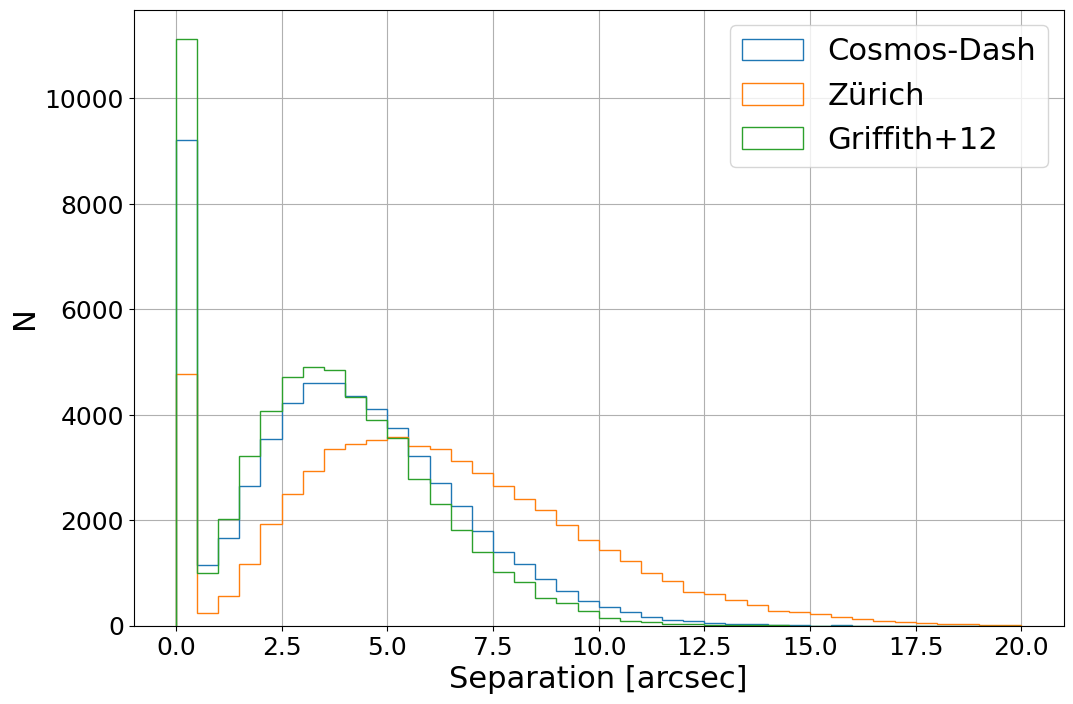

In [19]:
sep_bins = np.linspace(0,20,41)
plt.hist(sep2d_hst.arcsec, histtype='step', label='Cosmos-Dash', bins=sep_bins)
plt.hist(sep2d_zur.arcsec, histtype='step', label='Zürich', bins=sep_bins)
plt.hist(sep2d_gri.arcsec, histtype='step', label='Griffith+12', bins=sep_bins)
plt.legend(loc=0)
plt.xlabel('Separation [arcsec]')
plt.ylabel('N')
#plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/separation_with_other_surveys.png', format='png')
plt.grid()
plt.show()

In [20]:
df['match_hst'], df['sep_hst'] = idx_hst, sep2d_hst.arcsec
df['match_zur'], df['sep_zur'] = idx_zur, sep2d_zur.arcsec
df['match_gri'], df['sep_gri'] = idx_gri, sep2d_gri.arcsec

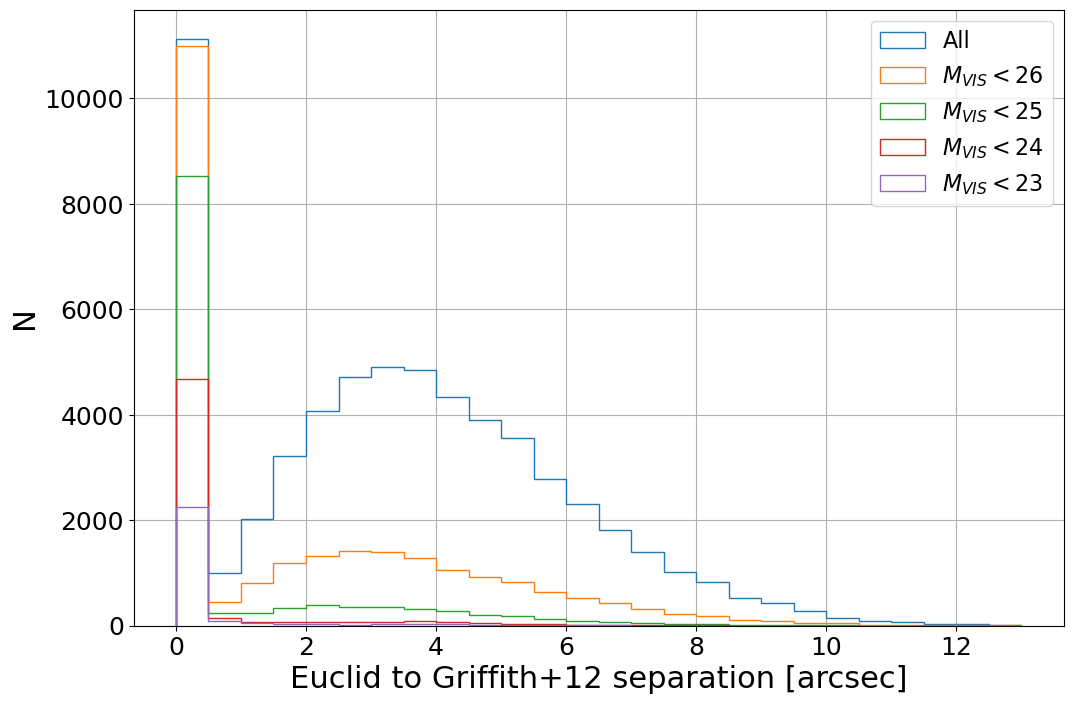

In [21]:
sep_bins = np.linspace(0,13,27)

sep = df.sep_gri
plt.hist(sep, histtype='step', label='All', bins=sep_bins)

for mag_lim in [26,25,24,23]:
    sep = df[df.MAG_VIS_SERSIC < mag_lim].sep_gri
    plt.hist(sep, histtype='step', label='$M_{VIS} < $'+str(mag_lim), bins=sep_bins)


plt.legend(loc=0, fontsize=16)
plt.xlabel('Euclid to Griffith+12 separation [arcsec]')
plt.ylabel('N')
#plt.yscale('log')
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/separation_with_Griffith_mag_effect.png', format='png')
plt.grid()
plt.show()

C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


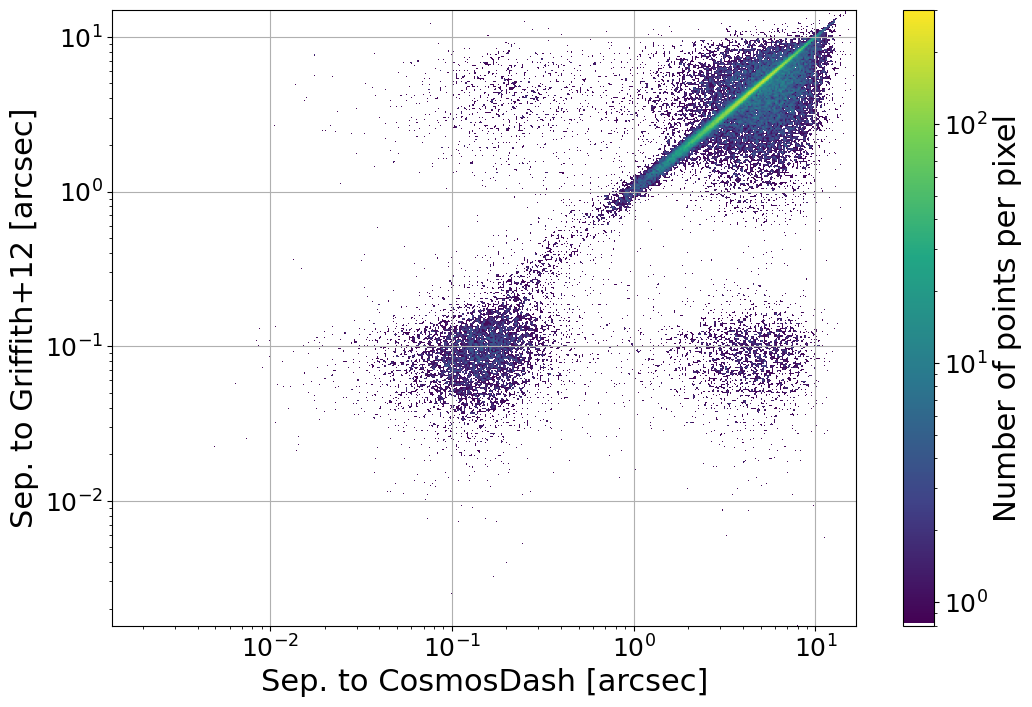

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

x, y = df['sep_hst'], df['sep_gri']
density = ax.scatter_density(x, y, norm=mpl.colors.LogNorm(vmin=0.8, vmax=300), cmap=white_viridis)
                           
fig.colorbar(density, label='Number of points per pixel')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sep. to CosmosDash [arcsec]')
plt.ylabel('Sep. to Griffith+12 [arcsec]')
plt.grid()    
plt.show()

In [23]:
df = df.merge(df_hst, left_on='match_hst', right_index=True, how='left', suffixes=[None, '_hst'])
df = df.merge(df_zur, left_on='match_zur', right_index=True, how='left', suffixes=[None, '_zur'])
df = df.merge(df_gri, left_on='match_gri', right_index=True, how='left', suffixes=[None, '_gri'])

In [24]:
df.columns.values

array(['OBJECT_ID', 'RIGHT_ASCENSION', 'DECLINATION',
       'RIGHT_ASCENSION_PSF_FITTING', 'DECLINATION_PSF_FITTING',
       'SEGMENTATION_MAP_ID', 'VIS_DET', 'FLUX_VIS_APER', 'FLUX_Y_APER',
       'FLUX_J_APER', 'FLUX_H_APER', 'FLUX_NIR_STACK_APER',
       'FLUX_U_EXT_DECAM_APER', 'FLUX_G_EXT_DECAM_APER',
       'FLUX_R_EXT_DECAM_APER', 'FLUX_I_EXT_DECAM_APER',
       'FLUX_Z_EXT_DECAM_APER', 'FLUX_U_EXT_LSST_APER',
       'FLUX_G_EXT_LSST_APER', 'FLUX_R_EXT_LSST_APER',
       'FLUX_I_EXT_LSST_APER', 'FLUX_Z_EXT_LSST_APER',
       'FLUX_U_EXT_MEGACAM_APER', 'FLUX_R_EXT_MEGACAM_APER',
       'FLUX_G_EXT_JPCAM_APER', 'FLUX_I_EXT_PANSTARRS_APER',
       'FLUX_Z_EXT_PANSTARRS_APER', 'FLUX_G_EXT_HSC_APER',
       'FLUX_Z_EXT_HSC_APER', 'FLUXERR_VIS_APER', 'FLUXERR_Y_APER',
       'FLUXERR_J_APER', 'FLUXERR_H_APER', 'FLUXERR_NIR_STACK_APER',
       'FLUXERR_U_EXT_DECAM_APER', 'FLUXERR_G_EXT_DECAM_APER',
       'FLUXERR_R_EXT_DECAM_APER', 'FLUXERR_I_EXT_DECAM_APER',
       'FLUXERR_Z_EXT_DE

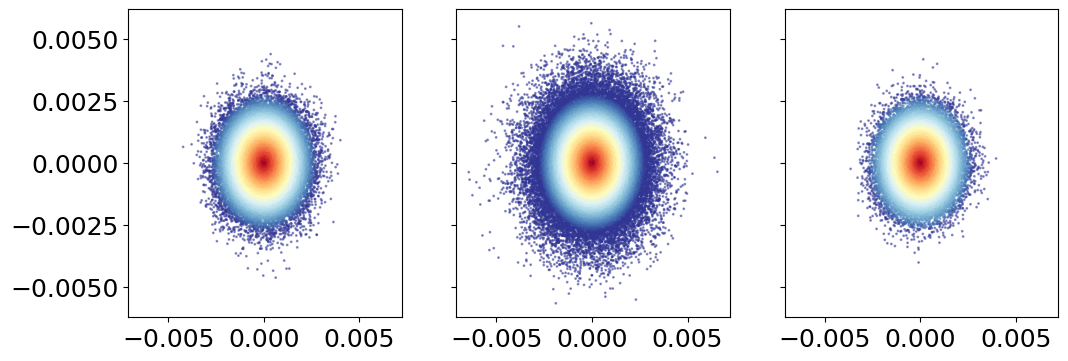

In [25]:
fig, ax = plt.subplots(1,3, sharey=True, sharex=True, figsize=(12,4))

ax[0].scatter(df['RIGHT_ASCENSION'] - df['RA'], df['DECLINATION'] - df['DEC'], c = df['sep_hst'], cmap='RdYlBu',
            s=1, alpha = 0.5, vmin=0.0, vmax=10.0)
ax[1].scatter(df['RIGHT_ASCENSION'] - df['RA_zur'], df['DECLINATION'] - df['DEC_zur'], c = df['sep_zur'], cmap='RdYlBu',
            s=1, alpha = 0.5, vmin=0.0, vmax=10.0)
ax[2].scatter(df['RIGHT_ASCENSION'] - df['RAJ2000'], df['DECLINATION'] - df['DEJ2000'], c = df['sep_gri'], cmap='RdYlBu',
            s=1, alpha = 0.5, vmin=0.0, vmax=10.0)
plt.show()

## Compare results

In [26]:
mag_bins_VIS = np.array([18.,20.,22.,23.,23.5,24.,24.5,25.,25.5,26.,27.,28.,30])
mag_bins_814 = np.array([18,20,21,22,22.5,23,23.5,24,24.5,25,25.5,26])
mag_bins_160 = np.array([17,20,21,21.5,22,22.5,23,23.5,24,24.5])

### vs Griffith+12

In [27]:
df_gri.columns

Index(['ObjNo', 'RAJ2000', 'DEJ2000', 'f1', 'f2', 'z', 'umag', 'gmag', 'rmag',
       'imag', 'Class', 'mu1', 'mu2', 'Sf1', 'Gf1', 's/g1', 's/g2', 'mGal1',
       'e_mGal1', 'mGal2', 'e_mGal2', 'Re.G1', 'e_Re.G1', 'Re.G2', 'e_Re.G2',
       'n.G1', 'e_n.G1', 'n.G2', 'e_n.G2', 'b/a.G1', 'e_b/a.G1', 'b/a.G2',
       'e_b/a.G2', 'pa.G1', 'e_pa.G1', 'pa.G2', 'e_pa.G2'],
      dtype='object')

(12066, 632)


C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
C:\Users\quilley\AppData\Local\anaconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


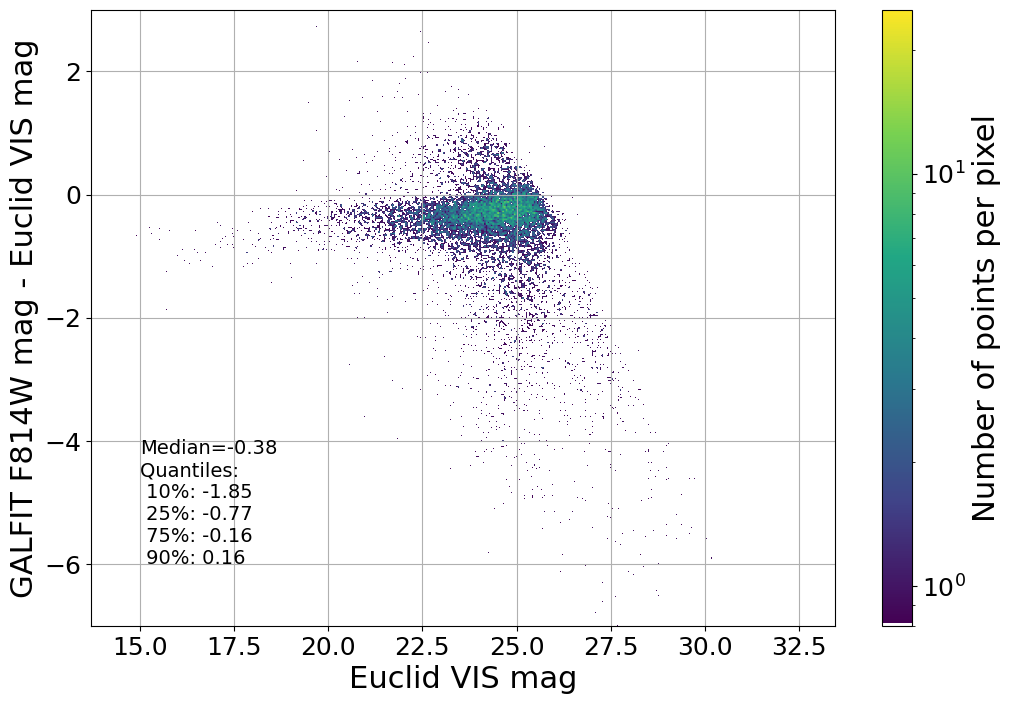

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

df_plot = df[(df.sep_gri < 1) & (df.e_mGal1 < 3) & (df.MAGERR_VIS_SERSIC < 3)]
print(df_plot.shape)

x, x_err = df_plot['MAG_VIS_SERSIC'].values, df_plot['MAGERR_VIS_SERSIC'].values
y, y_err = df_plot['mGal1'].values, df_plot['e_mGal1'].values

err_y = np.sqrt(x_err*x_err + y_err*y_err)

density = ax.scatter_density(x, y-x, norm=mpl.colors.LogNorm(vmin=0.8, vmax=25), cmap=white_viridis)

med = np.round(np.median(y-x),2)
q10 = np.round(np.quantile(y-x,0.10),2)
q25 = np.round(np.quantile(y-x,0.25),2)
q75 = np.round(np.quantile(y-x,0.75),2)
q90 = np.round(np.quantile(y-x,0.90),2)
plt.text(15,-6,'Median='+str(med)+'\n'+'Quantiles: \n 10%: '+str(q10)+'\n 25%: '+str(q25)+'\n 75%: '+str(q75)+'\n 90%: '+str(q90), fontsize=14)

fig.colorbar(density, label='Number of points per pixel')
plt.xlabel('Euclid VIS mag')
plt.ylabel('GALFIT F814W mag - Euclid VIS mag')
plt.ylim(-7,3)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_Griffith12_photometry_plot_density.png', format='png')
plt.show()

(12066, 632)


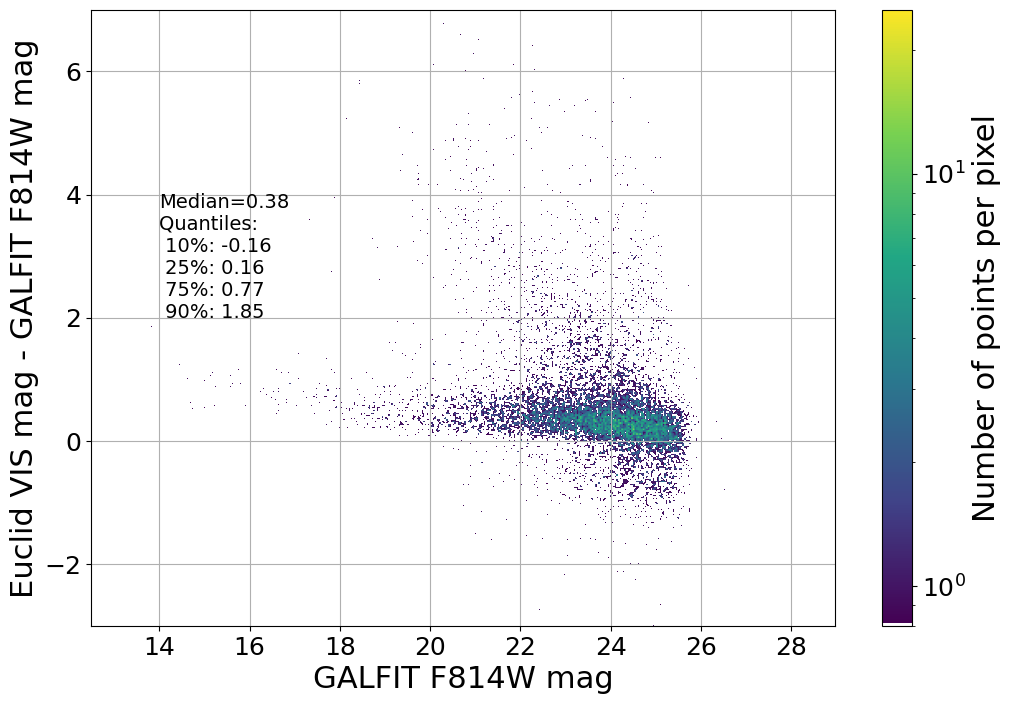

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

df_plot = df[(df.sep_gri < 1) & (df.e_mGal1 < 3) & (df.MAGERR_VIS_SERSIC < 3)]
print(df_plot.shape)

x, x_err = df_plot['MAG_VIS_SERSIC'].values, df_plot['MAGERR_VIS_SERSIC'].values
y, y_err = df_plot['mGal1'].values, df_plot['e_mGal1'].values

err_y = np.sqrt(x_err*x_err + y_err*y_err)

density = ax.scatter_density(y, x-y, norm=mpl.colors.LogNorm(vmin=0.8, vmax=25), cmap=white_viridis)

med = np.round(np.median(x-y),2)
q10 = np.round(np.quantile(x-y,0.10),2)
q25 = np.round(np.quantile(x-y,0.25),2)
q75 = np.round(np.quantile(x-y,0.75),2)
q90 = np.round(np.quantile(x-y,0.90),2)
plt.text(14,2,'Median='+str(med)+'\n'+'Quantiles: \n 10%: '+str(q10)+'\n 25%: '+str(q25)+'\n 75%: '+str(q75)+'\n 90%: '+str(q90), fontsize=14)

fig.colorbar(density, label='Number of points per pixel')
plt.xlabel('GALFIT F814W mag')
plt.ylabel('Euclid VIS mag - GALFIT F814W mag')
plt.ylim(-3,7)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_Griffith12_photometry_plot_density_bis.png', format='png')
plt.show()

0.3809213256835946 0.297572546386718 0.1542772375144223


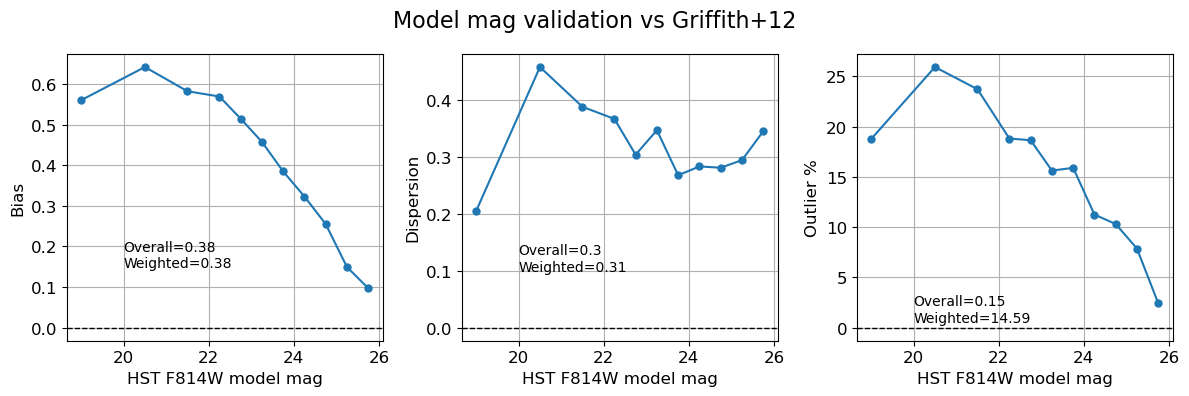

In [30]:
df_plot = df[(df.sep_gri < 1)]

x, y = df_plot['mGal1'].values, df_plot['MAG_VIS_SERSIC'].values

b = y-x
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_814)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_814[k], mag_bins_814[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = df_use['mGal1'].values, df_use['MAG_VIS_SERSIC'].values 
        b = y-x
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_814[1:] + mag_bins_814[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(20, 0.15, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10)
axs[1].text(20, 0.1, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10)
axs[2].text(20, 0.6, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F814W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Model mag validation vs Griffith+12', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_magnitude_vs_Griffith12.png', format='png')
plt.show()

12134
2994


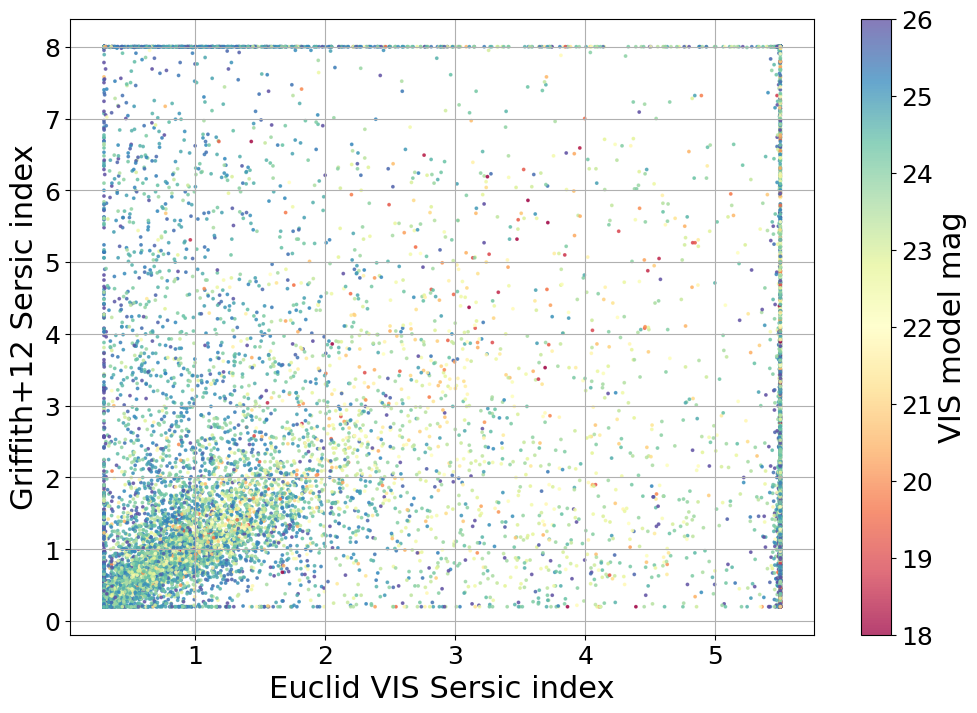

In [31]:
df_plot = df[(df.sep_gri < 1)]
print(df_plot.shape[0])

x0, x0err = df_plot['SERSIC_SERSIC_INDEX'].values, df_plot['SERSIC_SERSIC_INDEX_ERR'].values
x1, x1err = df_plot['n.G1'].values, df_plot['e_n.G1'].values
#z=df_plot['SERSIC_REDUCED_CHI2']
z=df_plot['MAG_VIS_SERSIC']

print(np.sum(x0 > 5.45))
#plt.scatter(x0, x1, s=3, alpha=0.75, ls='', c=z, cmap='Spectral_r', norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))
plt.scatter(x0, x1, s=3, alpha=0.75, ls='', c=z, cmap='Spectral', norm=mpl.colors.Normalize(vmin=18, vmax=26))
#plt.errorbar(x0, x1, xerr=x0err, yerr=x1err, markersize=2, alpha=0.5, ls='')

cbar = plt.colorbar()
#cbar.set_label(r'SE++ Reduced $\chi_2$')
cbar.set_label(r'VIS model mag')

plt.xlabel('Euclid VIS Sersic index')
plt.ylabel('Griffith+12 Sersic index')
#plt.xlim(0,6)
#plt.ylim(0,6)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_Griffith12_Sersic_index.png', format='png')
plt.show()

6725
1586


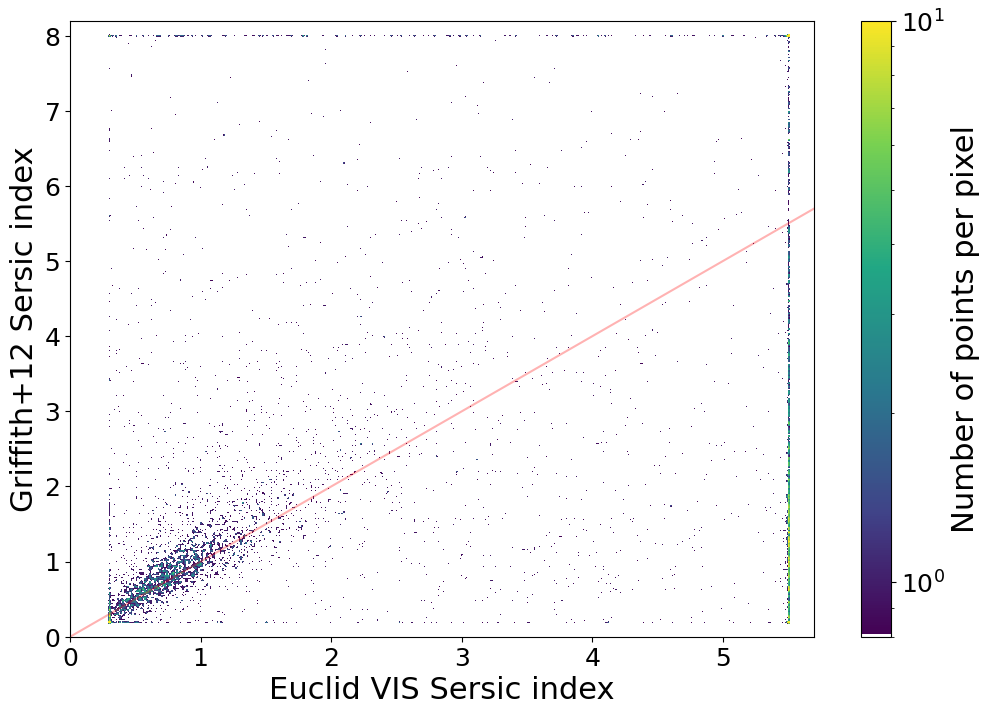

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

df_plot = df[(df.sep_gri < 1) & (df.MAG_VIS_SERSIC < 24.5)]
print(df_plot.shape[0])

x0, x0err = df_plot['SERSIC_SERSIC_INDEX'].values, df_plot['SERSIC_SERSIC_INDEX_ERR'].values
x1, x1err = df_plot['n.G1'].values, df_plot['e_n.G1'].values

print(np.sum(x0 > 5.45))

density = ax.scatter_density(x0, x1, norm=mpl.colors.LogNorm(vmin=0.8, vmax=10), cmap=white_viridis)

fig.colorbar(density, label='Number of points per pixel')

xa = np.linspace(0,10,100)
plt.plot(xa,xa,c='r', alpha=0.3)

plt.xlabel('Euclid VIS Sersic index')
plt.ylabel('Griffith+12 Sersic index')
plt.xlim(0,5.7)
plt.ylim(0,8.2)
#plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_Griffith12_Sersic_index_cut_mag24.5.png', format='png')
plt.show()

-0.06000476837158164 2.560829982757568 0.0


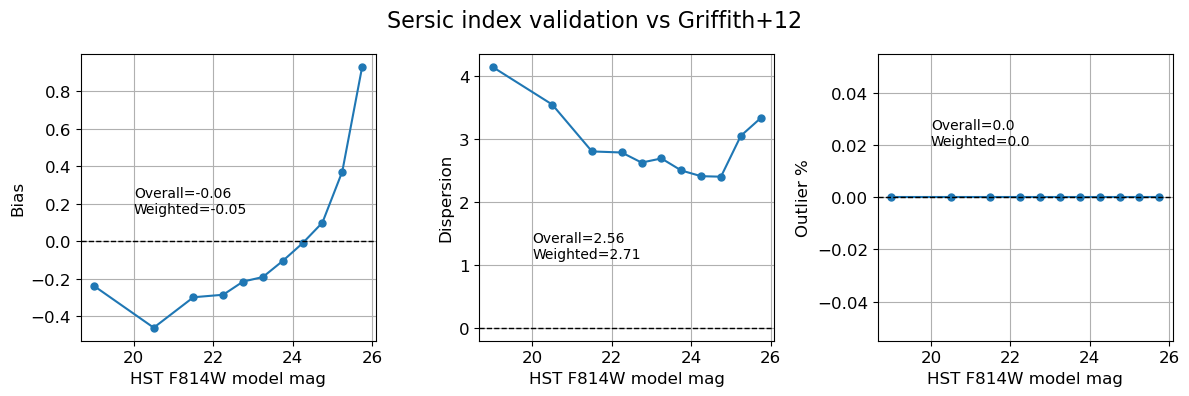

In [33]:
df_plot = df[(df.sep_gri < 1)]

x, y = df_plot['n.G1'].values, df_plot['SERSIC_SERSIC_INDEX'].values

b = y-x
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_814)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_814[k], mag_bins_814[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = df_use['n.G1'].values, df_use['SERSIC_SERSIC_INDEX'].values
        b = y-x
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_814[1:] + mag_bins_814[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(20, 0.15, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10)
axs[1].text(20, 1.1, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10)
axs[2].text(20, 0.02, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F814W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Sersic index validation vs Griffith+12', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_sersic_index_vs_Griffith12.png', format='png')
plt.show()

-0.02859122232782888 0.4646684006667151 0.014834349761002143


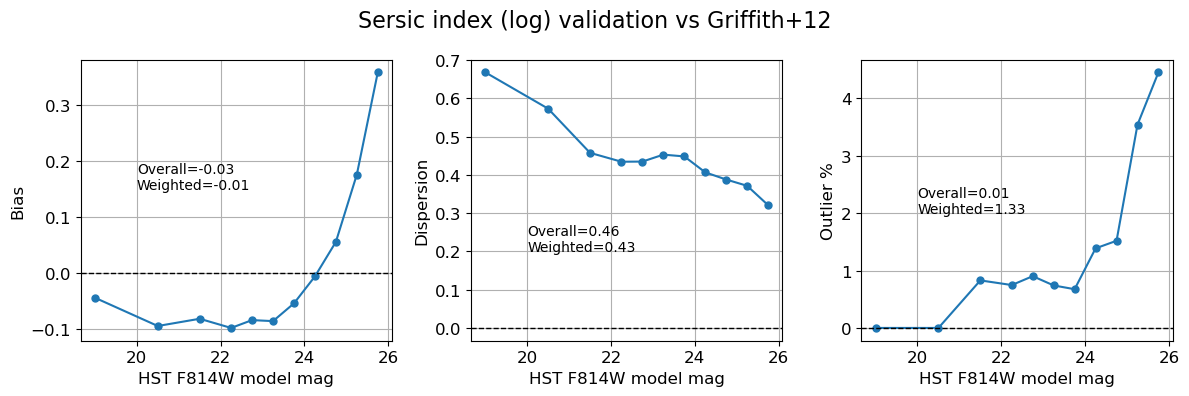

In [34]:
df_plot = df[(df.sep_gri < 1)]

x, y = df_plot['n.G1'].values, df_plot['SERSIC_SERSIC_INDEX'].values

b = np.log10(y/x)
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_814)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_814[k], mag_bins_814[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = df_use['n.G1'].values, df_use['SERSIC_SERSIC_INDEX'].values
        b = np.log10(y/x)
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_814[1:] + mag_bins_814[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(20, 0.15, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10)
axs[1].text(20, 0.2, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10)
axs[2].text(20, 2.0, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F814W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Sersic index (log) validation vs Griffith+12', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_log_sersic_index_vs_Griffith12.png', format='png')
plt.show()

3811


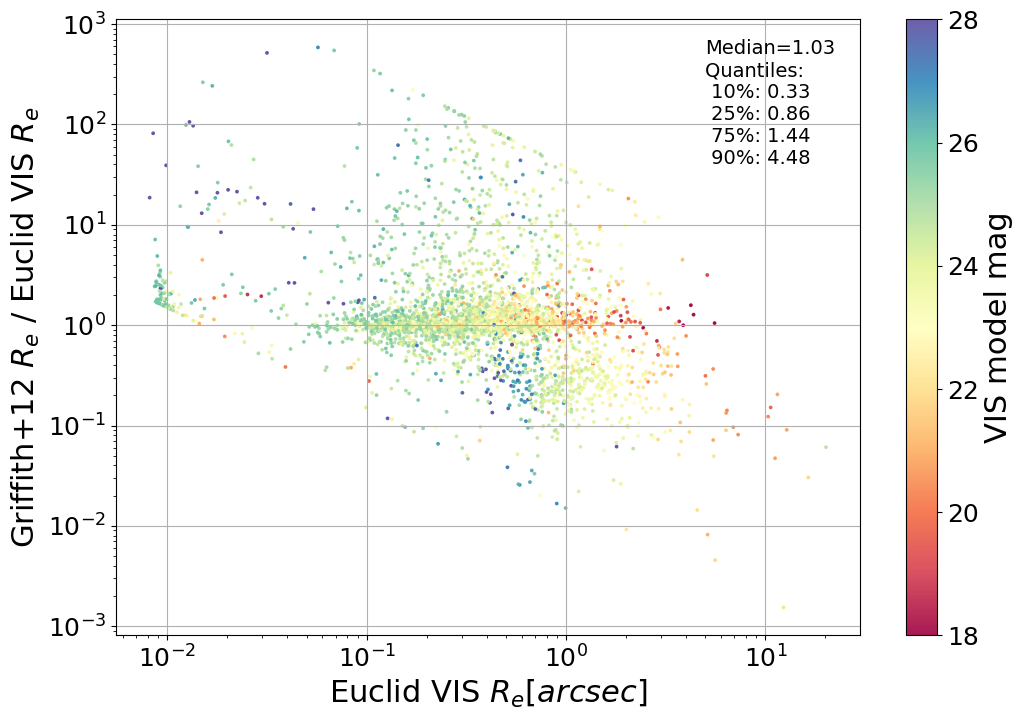

In [35]:
df_plot = df[(df.sep_gri < 1) & (df.re > 0)]
print(df_plot.shape[0])

x0, x0err = 0.1*df_plot['SERSIC_SERSIC_RADIUS'].values, 0.1*df_plot['SERSIC_SERSIC_RADIUS_ERR'].values
x1, x1err = 0.05*df_plot['Re.G1'].values, 0.05*df_plot['e_Re.G1'].values
z=df_plot['MAG_VIS_SERSIC']

q10 = np.round(np.quantile(x1/x0,0.10),2)
q25 = np.round(np.quantile(x1/x0,0.25),2)
q75 = np.round(np.quantile(x1/x0,0.75),2)
q90 = np.round(np.quantile(x1/x0,0.90),2)
plt.text(5,40,'Median='+str(np.round(np.median(x1/x0),2))+'\n'+'Quantiles: \n 10%: '+str(q10)+'\n 25%: '+str(q25)+'\n 75%: '+str(q75)+'\n 90%: '+str(q90), fontsize=14)

plt.scatter(x0, x1/x0, s=3, alpha=0.9, ls='', c=z, cmap='Spectral', norm=mpl.colors.Normalize(vmin=18, vmax=28))
#plt.errorbar(x0, x1, xerr=x0err, yerr=x1err, markersize=2, alpha=0.5, ls='')

cbar = plt.colorbar()
cbar.set_label(r'VIS model mag')

plt.xlabel('Euclid VIS $R_e [arcsec]$')
plt.ylabel('Griffith+12 $R_e$ / Euclid VIS $R_e$')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0,6)
#plt.ylim(0,6)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_Griffith12_Re.png', format='png')
plt.show()

-0.014483254384728157 0.32559464264562854 0.021757046316136477


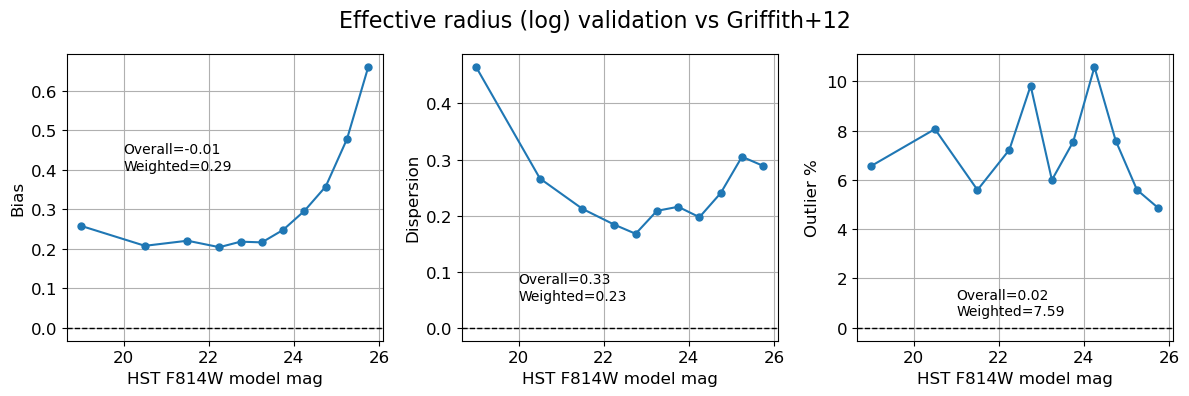

In [36]:
df_plot = df[(df.sep_gri < 1)]

x, y = 0.05*df_plot['Re.G1'].values, 0.1*df_plot['SERSIC_SERSIC_RADIUS'].values, 

b = np.log10(y/x)
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_814)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_814[k], mag_bins_814[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = 0.05*df_use['n.G1'].values, 0.1*df_use['SERSIC_SERSIC_INDEX'].values
        b = np.log10(y/x)
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_814[1:] + mag_bins_814[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(20, 0.4, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10)
axs[1].text(20, 0.05, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10)
axs[2].text(21, 0.5, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F814W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Effective radius (log) validation vs Griffith+12', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_sersic_Re_vs_Griffith12.png', format='png')
plt.show()

-0.03279898052580145 0.6463719674024899 0.10977418823141585


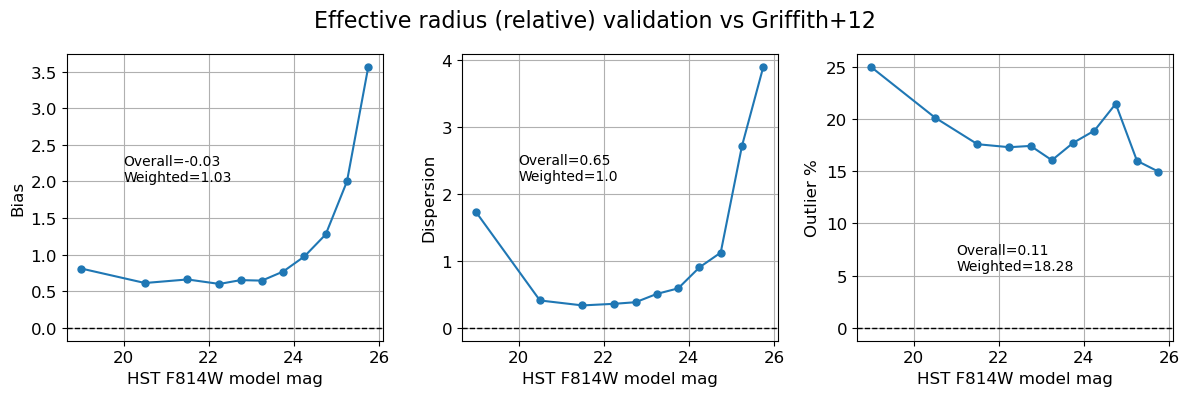

In [37]:
df_plot = df[(df.sep_gri < 1)]

x, y = 0.05*df_plot['Re.G1'].values, 0.1*df_plot['SERSIC_SERSIC_RADIUS'].values, 

b = (y-x)/x
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_814)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_814[k], mag_bins_814[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = 0.05*df_use['n.G1'].values, 0.1*df_use['SERSIC_SERSIC_INDEX'].values
        b = (y-x)/x
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_814[1:] + mag_bins_814[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(20, 2.0, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10)
axs[1].text(20, 2.2, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10)
axs[2].text(21, 5.5, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F814W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Effective radius (relative) validation vs Griffith+12', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_sersic_Re_rel_vs_Griffith12.png', format='png')
plt.show()

### vs CosmosDash catalog

In [38]:
df_hst.columns

Index(['ID', 'RA', 'DEC', 'flag', 'use', 'mag', 'dmag', 're', 'dre', 'n', 'dn',
       'q', 'dq', 'pa', 'dpa', 'kron', 'f_F160W_auto', 'e_F160W_auto',
       'f_F160W_tot', 'e_F160W_tot', 'snr', 'flag_limit_r', 'flag_limit_n',
       'flag_deb', 'Mcorr', '5_sigma_depth', 'chi', 'chi_nu', 'mag_F160W_auto',
       'mag_err_F160W_auto', 'mag_F160W_tot', 'mag_err_F160W_tot'],
      dtype='object')

2198


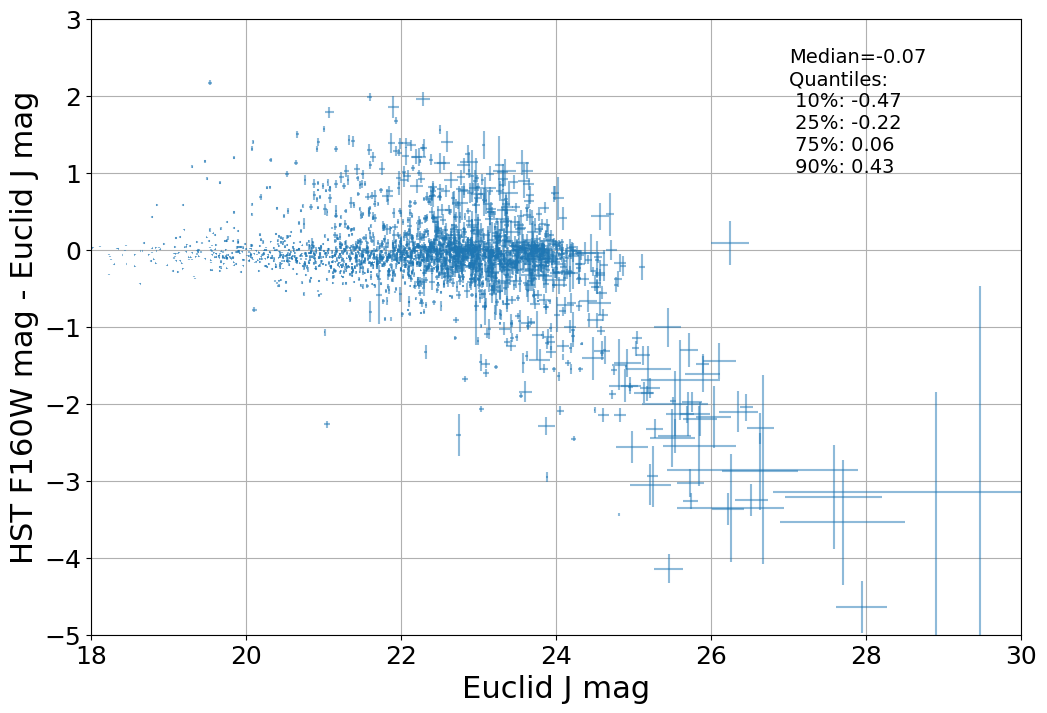

In [39]:
df_plot = df[(df.sep_hst < 1) & (df.mag > -99) & (df.use==1) & (df.MAGERR_J_APER > 0) & (df.MAGERR_J_SERSIC> 0)]
print(df_plot.shape[0])

x0, x0_err = df_plot['MAG_J_SERSIC'].values, df_plot['MAGERR_J_SERSIC'].values
y0, y0_err = df_plot['mag'].values, df_plot['dmag'].values

x1, x1_err = df_plot['MAG_J_APER'].values, df_plot['MAGERR_J_APER'].values
y1, y1_err = df_plot['mag_F160W_auto'].values, df_plot['mag_err_F160W_auto'].values
y2, y2_err = df_plot['mag_F160W_tot'].values, df_plot['mag_err_F160W_tot'].values

err_y0 = np.sqrt(x0_err*x0_err + y0_err*y0_err)
err_y1 = np.sqrt(x1_err*x1_err + y1_err*y1_err)
err_y2 = np.sqrt(x1_err*x1_err + y2_err*y2_err)

plt.errorbar(x0, y0-x0, xerr=x0_err, yerr=err_y0, markersize=2, alpha=0.5, ls='', label='Model')
#plt.errorbar(x1, y2-x1, xerr=x1_err, yerr=err_y2, markersize=2, alpha=0.5, ls='', label='Auto - Aper')

q10 = np.round(np.quantile(y0-x0,0.10),2)
q25 = np.round(np.quantile(y0-x0,0.25),2)
q75 = np.round(np.quantile(y0-x0,0.75),2)
q90 = np.round(np.quantile(y0-x0,0.90),2)
plt.text(27,1,'Median='+str(np.round(np.median(y0-x0),2))+'\n'+'Quantiles: \n 10%: '+str(q10)+'\n 25%: '+str(q25)+'\n 75%: '+str(q75)+'\n 90%: '+str(q90), fontsize=14)


plt.xlim(18,30)
plt.ylim(-5,3)

#plt.legend()
plt.xlabel('Euclid J mag')
plt.ylabel('HST F160W mag - Euclid J mag')
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_CosmosDash_photometry.png', format='png')
plt.show()

2198


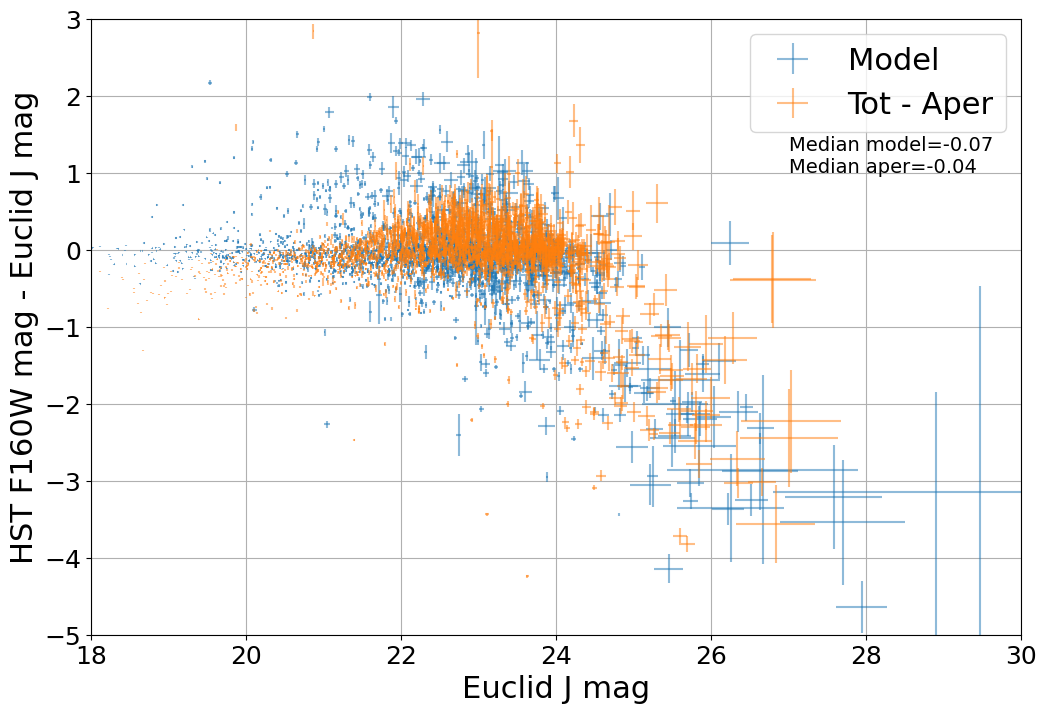

In [40]:
df_plot = df[(df.sep_hst < 1) & (df.mag > -99) & (df.use==1) & (df.MAGERR_J_APER > 0) & (df.MAGERR_J_SERSIC> 0)]
print(df_plot.shape[0])

x0, x0_err = df_plot['MAG_J_SERSIC'].values, df_plot['MAGERR_J_SERSIC'].values
y0, y0_err = df_plot['mag'].values, df_plot['dmag'].values

x1, x1_err = df_plot['MAG_J_APER'].values, df_plot['MAGERR_J_APER'].values
y1, y1_err = df_plot['mag_F160W_auto'].values, df_plot['mag_err_F160W_auto'].values
y2, y2_err = df_plot['mag_F160W_tot'].values, df_plot['mag_err_F160W_tot'].values

err_y0 = np.sqrt(x0_err*x0_err + y0_err*y0_err)
err_y1 = np.sqrt(x1_err*x1_err + y1_err*y1_err)
err_y2 = np.sqrt(x1_err*x1_err + y2_err*y2_err)

plt.errorbar(x0, y0-x0, xerr=x0_err, yerr=err_y0, markersize=2, alpha=0.5, ls='', label='Model')
plt.errorbar(x1, y2-x1, xerr=x1_err, yerr=err_y2, markersize=2, alpha=0.5, ls='', label='Tot - Aper')

plt.text(27,1,'Median model='+str(np.round(np.median(y0-x0),2))+'\n'+'Median aper='+str(np.round(np.median(y2-x1),2)),
         fontsize = 14)

plt.xlim(18,30)
plt.ylim(-5,3)

plt.legend()
plt.xlabel('Euclid J mag')
plt.ylabel('HST F160W mag - Euclid J mag')
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_CosmosDash_photometry_model_and_aper.png', format='png')
plt.show()

2198


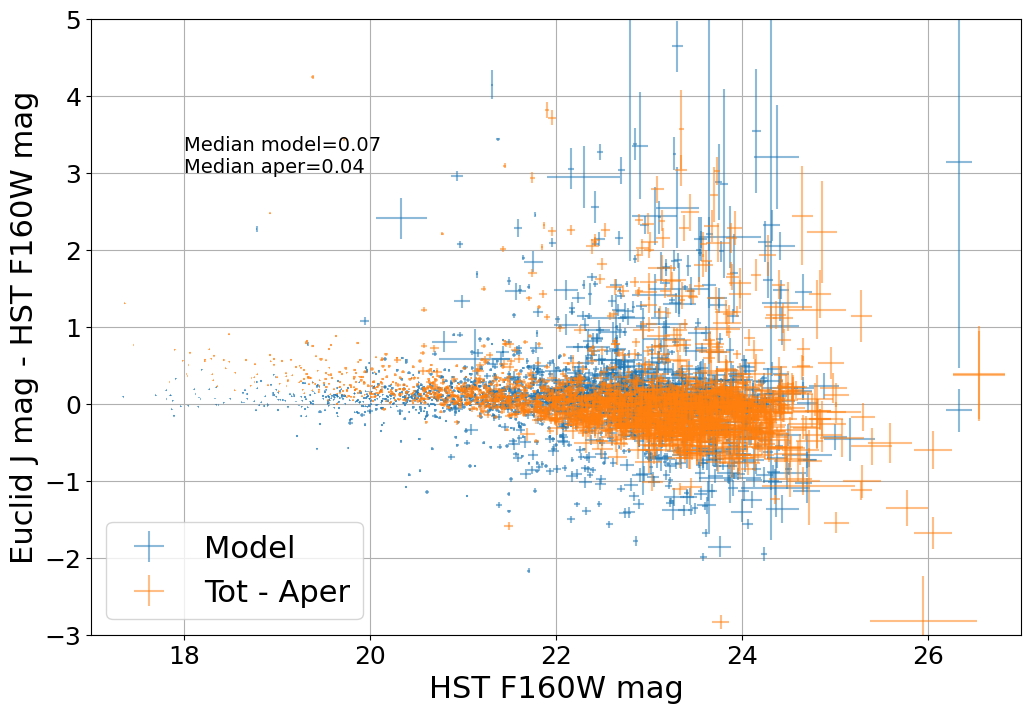

In [41]:
df_plot = df[(df.sep_hst < 1) & (df.mag > -99) & (df.use==1) & (df.MAGERR_J_APER > 0) & (df.MAGERR_J_SERSIC> 0)]
print(df_plot.shape[0])

x0, x0_err = df_plot['MAG_J_SERSIC'].values, df_plot['MAGERR_J_SERSIC'].values
y0, y0_err = df_plot['mag'].values, df_plot['dmag'].values

x1, x1_err = df_plot['MAG_J_APER'].values, df_plot['MAGERR_J_APER'].values
y1, y1_err = df_plot['mag_F160W_auto'].values, df_plot['mag_err_F160W_auto'].values
y2, y2_err = df_plot['mag_F160W_tot'].values, df_plot['mag_err_F160W_tot'].values

err_y0 = np.sqrt(x0_err*x0_err + y0_err*y0_err)
err_y1 = np.sqrt(x1_err*x1_err + y1_err*y1_err)
err_y2 = np.sqrt(x1_err*x1_err + y2_err*y2_err)

plt.errorbar(y0, x0-y0, xerr=y0_err, yerr=err_y0, markersize=2, alpha=0.5, ls='', label='Model')
plt.errorbar(y1, x1-y2, xerr=y2_err, yerr=err_y2, markersize=2, alpha=0.5, ls='', label='Tot - Aper')

plt.text(18,3,'Median model='+str(np.round(np.median(x0-y0),2))+'\n'+'Median aper='+str(np.round(np.median(x1-y2),2)),
        fontsize = 14)

plt.xlim(17,27)
plt.ylim(-3,5)

plt.legend()
plt.xlabel('HST F160W mag')
plt.ylabel('Euclid J mag - HST F160W mag')
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_CosmosDash_photometry_J_model_and_aper.png', format='png')
plt.show()

0.07414755249023486 0.20312597778320296 0.07142857142857142
0.043672787532932134 0.23498603392226777 0.060964513193812554


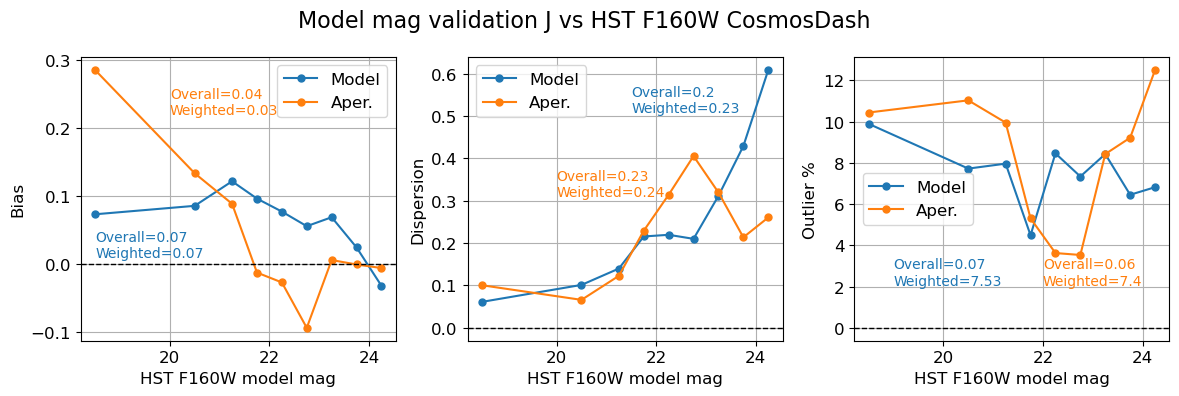

In [42]:
df_plot = df[(df.sep_hst < 1) & (df.mag > -99) & (df.use==1) & (df.MAGERR_J_APER > 0) & (df.MAGERR_J_SERSIC> 0)]

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

for i in range(2):
    if i==0:
        x, y = df_plot['mag'].values, df_plot['MAG_J_SERSIC'].values 
        c='tab:blue'
        lab='Model'
    else:
        x, y = df_plot['mag_F160W_tot'].values, df_plot['MAG_J_APER'].values
        c='tab:orange'
        lab='Aper.'

    b = y-x
    med = np.median(b)
    disp = np.quantile(np.abs(b)-med, 0.68)
    outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

    print(med, disp, outl)

    nb = len(mag_bins_160)-1
    B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
    for k in range(nb):
        m1, m2 = mag_bins_160[k], mag_bins_160[k+1]
        df_use = df_plot[(df_plot.mag >= m1) & (df_plot.mag < m2)]
        if df_use.shape[0] > 10 :
            if i==0:
                x, y = df_use['mag'].values, df_use['MAG_J_SERSIC'].values, 
            else:
                x, y = df_use['mag_F160W_tot'].values, df_use['MAG_J_APER'].values
            b = y-x
            B[k] = np.median(b)
            D[k] = np.quantile(np.abs(b)-B[k], 0.68)
            O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
        weight[k] = df_use.shape[0] / df_plot.shape[0]

    X = 0.5*(mag_bins_160[1:] + mag_bins_160[:-1])

    okB = np.isfinite(B)
    wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
    okD = np.isfinite(D)
    wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
    okO = np.isfinite(O)
    wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

    axs[0].plot(X, B, marker = 'o', markersize=5, c=c, label=lab)
    axs[1].plot(X, D, marker = 'o', markersize=5, c=c, label=lab)
    axs[2].plot(X, O, marker = 'o', markersize=5, c=c, label=lab)
    
    if i == 0:
        x0, x1, x2 = 18.5, 21.5, 19
        y0, y1, y2 = 0.01,0.51, 2.1
    else :
        x0, x1, x2 = 20, 20, 22
        y0, y1, y2 = 0.22, 0.31, 2.1
    axs[0].text(x0, y0, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10, c=c)
    axs[1].text(x1, y1, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10, c=c)
    axs[2].text(x2, y2, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10, c=c)

    axs[0].set_ylabel('Bias', fontsize = 12)
    axs[1].set_ylabel('Dispersion', fontsize = 12)
    axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F160W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()
    ax.legend(fontsize = 12)

fig.suptitle('Model mag validation J vs HST F160W CosmosDash', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_mag_J_vs_CosmosDash.png', format='png')
plt.show()

2198


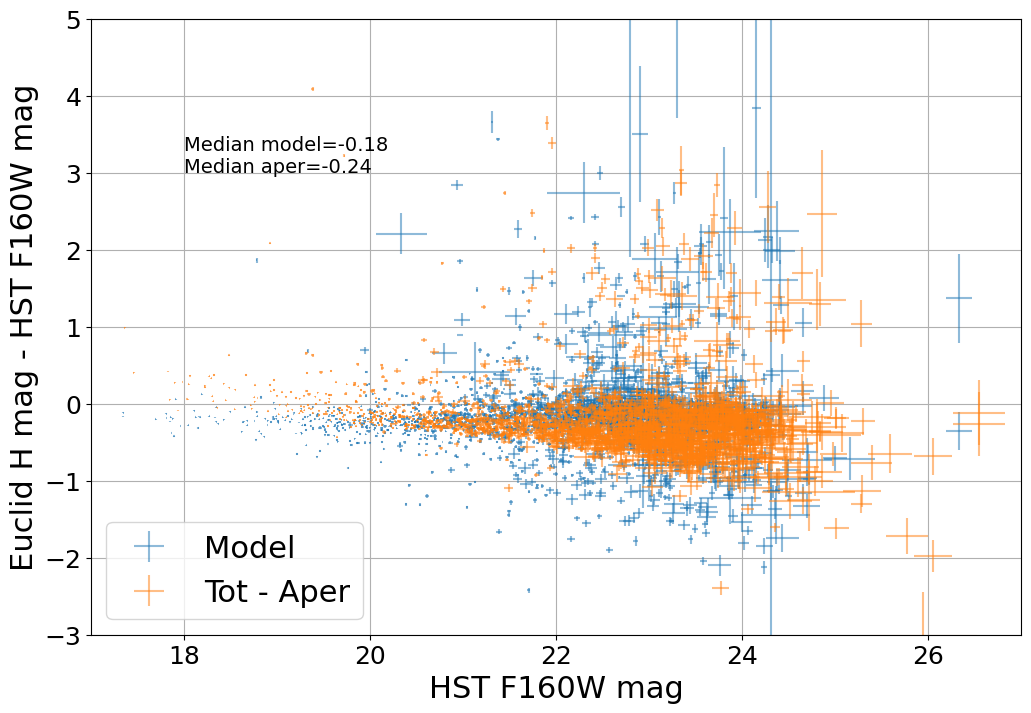

In [43]:
df_plot = df[(df.sep_hst < 1) & (df.mag > -99) & (df.use==1) & (df.MAGERR_J_APER > 0) & (df.MAGERR_J_SERSIC> 0)]
print(df_plot.shape[0])

x0, x0_err = df_plot['MAG_H_SERSIC'].values, df_plot['MAGERR_H_SERSIC'].values
y0, y0_err = df_plot['mag'].values, df_plot['dmag'].values

x1, x1_err = df_plot['MAG_H_APER'].values, df_plot['MAGERR_H_APER'].values
y1, y1_err = df_plot['mag_F160W_auto'].values, df_plot['mag_err_F160W_auto'].values
y2, y2_err = df_plot['mag_F160W_tot'].values, df_plot['mag_err_F160W_tot'].values

err_y0 = np.sqrt(x0_err*x0_err + y0_err*y0_err)
err_y1 = np.sqrt(x1_err*x1_err + y1_err*y1_err)
err_y2 = np.sqrt(x1_err*x1_err + y2_err*y2_err)

plt.errorbar(y0, x0-y0, xerr=y0_err, yerr=err_y0, markersize=2, alpha=0.5, ls='', label='Model')
plt.errorbar(y1, x1-y2, xerr=y2_err, yerr=err_y2, markersize=2, alpha=0.5, ls='', label='Tot - Aper')

plt.text(18,3,'Median model='+str(np.round(np.median(x0-y0),2))+'\n'+'Median aper='+str(np.round(np.median(x1-y2),2)),
        fontsize = 14)

plt.xlim(17,27)
plt.ylim(-3,5)

plt.legend()
plt.xlabel('HST F160W mag')
plt.ylabel('Euclid H mag - HST F160W mag')
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_CosmosDash_photometry_H_model_and_aper.png', format='png')
plt.show()

-0.1836960754394532 0.5225027331542986 0.0272975432211101
-0.24024060700830674 0.637448718538097 0.015468607825295723


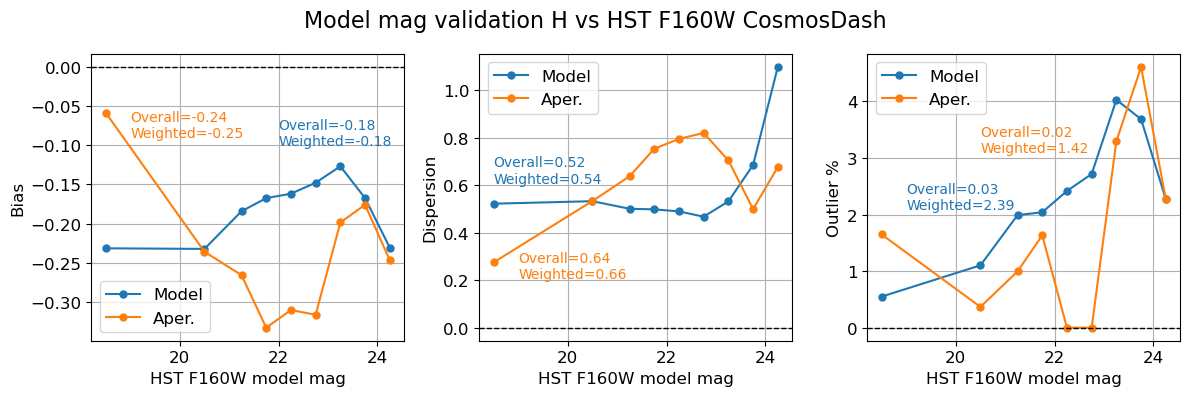

In [44]:
df_plot = df[(df.sep_hst < 1) & (df.mag > -99) & (df.use==1) & (df.MAGERR_J_APER > 0) & (df.MAGERR_J_SERSIC> 0)]

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

for i in range(2):
    if i==0:
        x, y = df_plot['mag'].values, df_plot['MAG_H_SERSIC'].values 
        c='tab:blue'
        lab='Model'
    else:
        x, y = df_plot['mag_F160W_tot'].values, df_plot['MAG_H_APER'].values
        c='tab:orange'
        lab='Aper.'

    b = y-x
    med = np.median(b)
    disp = np.quantile(np.abs(b)-med, 0.68)
    outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

    print(med, disp, outl)

    nb = len(mag_bins_160)-1
    B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
    for k in range(nb):
        m1, m2 = mag_bins_160[k], mag_bins_160[k+1]
        df_use = df_plot[(df_plot.mag >= m1) & (df_plot.mag < m2)]
        if df_use.shape[0] > 10 :
            if i==0:
                x, y = df_use['mag'].values, df_use['MAG_H_SERSIC'].values, 
            else:
                x, y = df_use['mag_F160W_tot'].values, df_use['MAG_H_APER'].values
            b = y-x
            B[k] = np.median(b)
            D[k] = np.quantile(np.abs(b)-B[k], 0.68)
            O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
        weight[k] = df_use.shape[0] / df_plot.shape[0]

    X = 0.5*(mag_bins_160[1:] + mag_bins_160[:-1])

    okB = np.isfinite(B)
    wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
    okD = np.isfinite(D)
    wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
    okO = np.isfinite(O)
    wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

    axs[0].plot(X, B, marker = 'o', markersize=5, c=c, label=lab)
    axs[1].plot(X, D, marker = 'o', markersize=5, c=c, label=lab)
    axs[2].plot(X, O, marker = 'o', markersize=5, c=c, label=lab)
    
    if i == 0:
        x0, x1, x2 = 22, 18.5, 19
        y0, y1, y2 = -0.1,0.61, 2.1
    else :
        x0, x1, x2 = 19, 19, 20.5
        y0, y1, y2 = -0.09, 0.21, 3.1
    axs[0].text(x0, y0, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 10, c=c)
    axs[1].text(x1, y1, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 10, c=c)
    axs[2].text(x2, y2, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 10, c=c)

    axs[0].set_ylabel('Bias', fontsize = 12)
    axs[1].set_ylabel('Dispersion', fontsize = 12)
    axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F160W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()
    ax.legend(fontsize = 12)

fig.suptitle('Model mag validation H vs HST F160W CosmosDash', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_mag_H_vs_CosmosDash.png', format='png')
plt.show()

2225


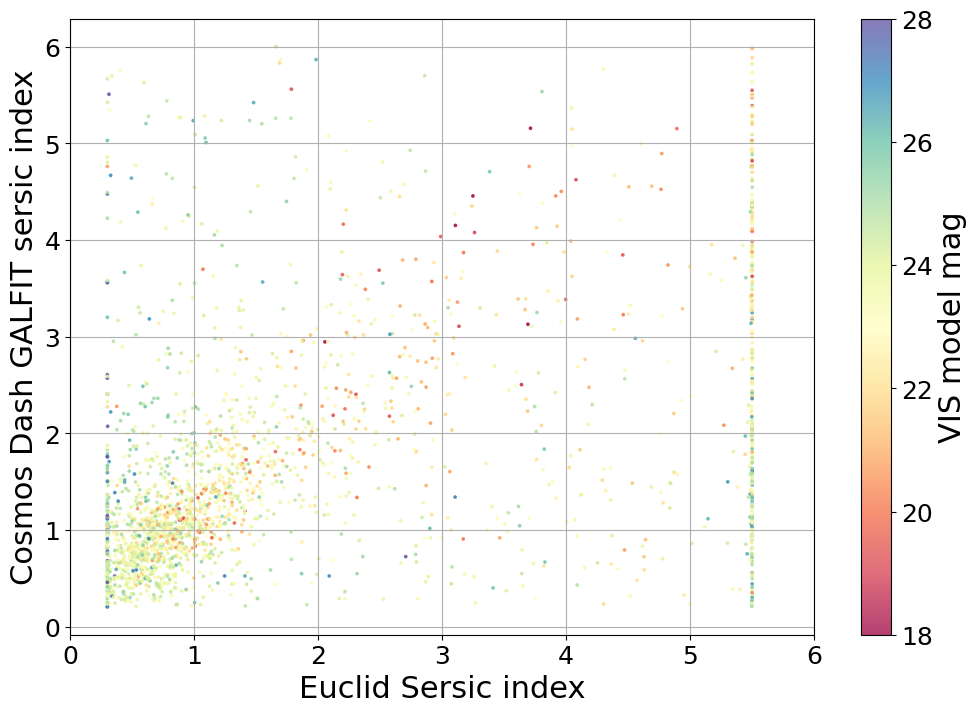

In [45]:
df_plot = df[(df.sep_hst < 1) & (df.use==1)]
print(df_plot.shape[0])

x0, x0err = df_plot['SERSIC_SERSIC_INDEX'].values, df_plot['SERSIC_SERSIC_INDEX_ERR'].values
x1, x1err = df_plot['n'].values, df_plot['dn'].values
#z=df_plot['SERSIC_REDUCED_CHI2']
z=df_plot['MAG_VIS_SERSIC']

#plt.scatter(x0, x1, s=3, alpha=0.75, ls='', c=z, cmap='Spectral_r', norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))
plt.scatter(x0, x1, s=3, alpha=0.75, ls='', c=z, cmap='Spectral', norm=mpl.colors.Normalize(vmin=18, vmax=28))
#plt.errorbar(x0, x1, xerr=x0err, yerr=x1err, markersize=2, alpha=0.5, ls='')

cbar = plt.colorbar()
#cbar.set_label(r'SE++ Reduced $\chi_2$')
cbar.set_label(r'VIS model mag')

plt.xlabel('Euclid Sersic index')
plt.ylabel('Cosmos Dash GALFIT sersic index')
plt.xlim(0,6)
#plt.ylim(0,6)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_CosmosDash_Sersic_index.png', format='png')
plt.show()

0.12297791671752933 0.8253599012184146 0.033707865168539325


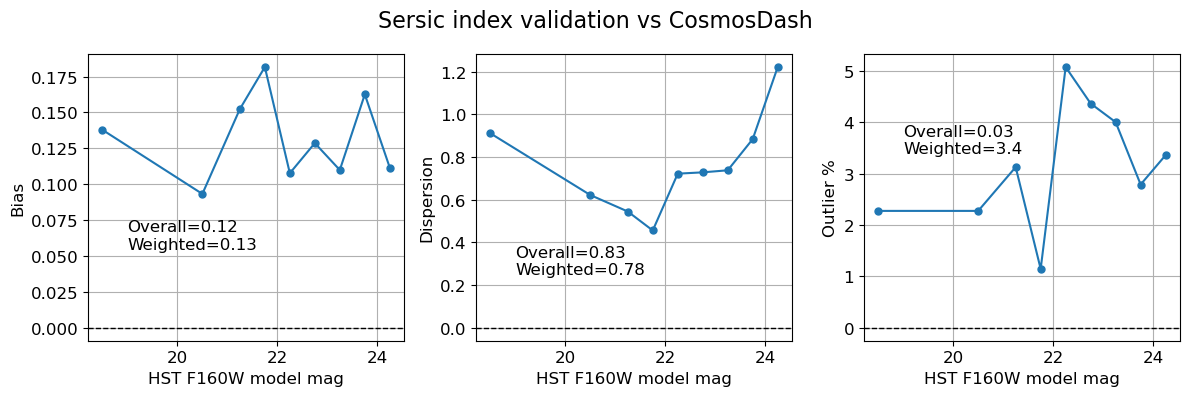

In [46]:
df_plot = df[(df.sep_hst < 1) & (df.use==1)]

x, y = df_plot['SERSIC_SERSIC_INDEX'].values, df_plot['n'].values

b = y-x
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_160)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_160[k], mag_bins_160[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = df_use['SERSIC_SERSIC_INDEX'].values, df_use['n'].values
        b = y-x
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_160[1:] + mag_bins_160[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(19, 0.055, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 12)
axs[1].text(19, 0.25, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 12)
axs[2].text(19, 3.4, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 12)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F160W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Sersic index validation vs CosmosDash', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_sersic_index_vs_CosmosDash.png', format='png')
plt.show()

2225


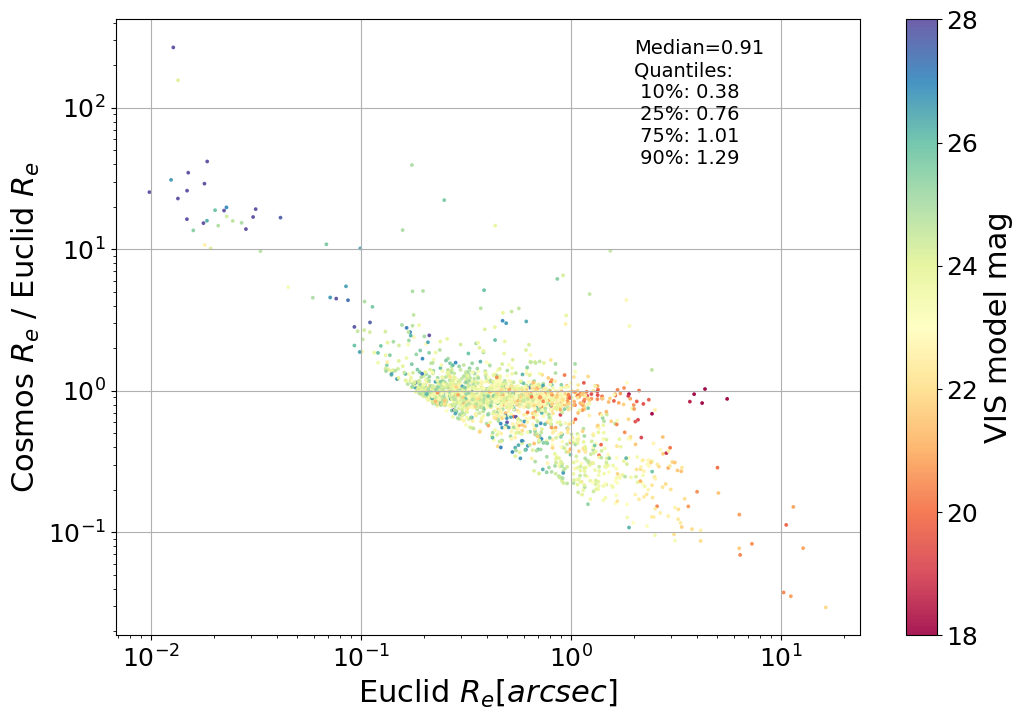

In [47]:
df_plot = df[(df.sep_hst < 1) & (df.re > 0) & (df.use==1)]
print(df_plot.shape[0])

x0, x0err = 0.1*df_plot['SERSIC_SERSIC_RADIUS'].values, 0.1*df_plot['SERSIC_SERSIC_RADIUS_ERR'].values
x1, x1err = df_plot['re'].values, df_plot['dre'].values
z=df_plot['MAG_VIS_SERSIC']

q10 = np.round(np.quantile(x1/x0,0.10),2)
q25 = np.round(np.quantile(x1/x0,0.25),2)
q75 = np.round(np.quantile(x1/x0,0.75),2)
q90 = np.round(np.quantile(x1/x0,0.90),2)
plt.text(2,40,'Median='+str(np.round(np.median(x1/x0),2))+'\n'+'Quantiles: \n 10%: '+str(q10)+'\n 25%: '+str(q25)+'\n 75%: '+str(q75)+'\n 90%: '+str(q90), fontsize=14)

plt.scatter(x0, x1/x0, s=3, alpha=0.9, ls='', c=z, cmap='Spectral', norm=mpl.colors.Normalize(vmin=18, vmax=28))
#plt.errorbar(x0, x1, xerr=x0err, yerr=x1err, markersize=2, alpha=0.5, ls='')

cbar = plt.colorbar()
cbar.set_label(r'VIS model mag')

plt.xlabel('Euclid $R_e [arcsec]$')
plt.ylabel('Cosmos $R_e$ / Euclid $R_e$')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0,6)
#plt.ylim(0,6)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_CosmosDash_Re.png', format='png')
plt.show()

-0.04261569151688961 0.17434208384019423 0.02606741573033708


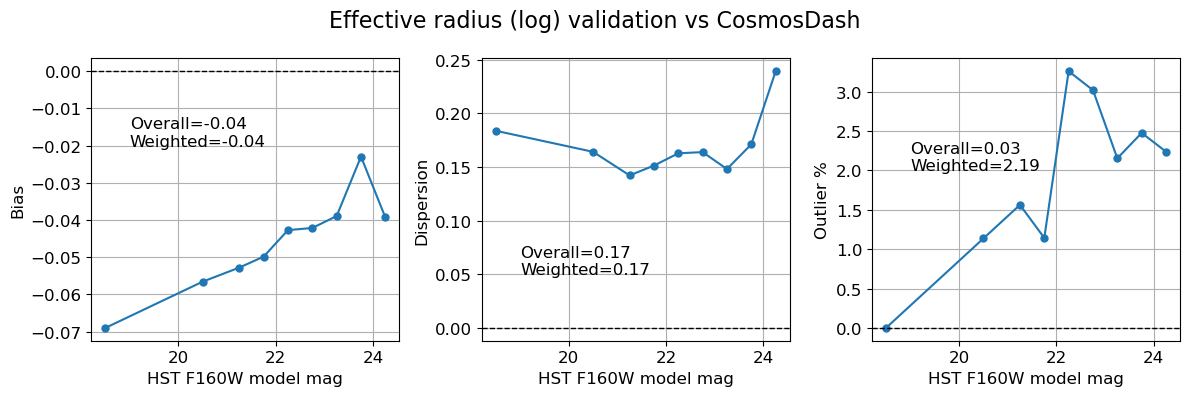

In [48]:
df_plot = df[(df.sep_hst < 1) & (df.re > 0) & (df.use==1)]

x, y = 0.1*df_plot['SERSIC_SERSIC_RADIUS'].values, df_plot['re'].values

b = np.log10(y/x)
med = np.median(b)
disp = np.quantile(np.abs(b)-med, 0.68)
outl = np.sum(b-med > 3*disp)/df_plot.shape[0]

print(med, disp, outl)

nb = len(mag_bins_160)-1
B, D, O, weight = np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb), np.repeat(np.nan, nb)
for k in range(nb):
    m1, m2 = mag_bins_160[k], mag_bins_160[k+1]
    df_use = df_plot[(df_plot.mGal1 >= m1) & (df_plot.mGal1 < m2)]
    if df_use.shape[0] > 10 :
        x, y = 0.1*df_use['SERSIC_SERSIC_RADIUS'].values, df_use['re'].values
        b = np.log10(y/x)
        B[k] = np.median(b)
        D[k] = np.quantile(np.abs(b)-B[k], 0.68)
        O[k] = 100*(np.sum(b-B[k] > 3*D[k])/df_use.shape[0])
    weight[k] = df_use.shape[0] / df_plot.shape[0]
        
X = 0.5*(mag_bins_160[1:] + mag_bins_160[:-1])

okB = np.isfinite(B)
wB = np.sum(B[okB]*weight[okB])/np.sum(weight[okB])
okD = np.isfinite(D)
wD = np.sum(D[okD]*weight[okD])/np.sum(weight[okD])
okO = np.isfinite(O)
wO = np.sum(O[okO]*weight[okO])/np.sum(weight[okO])

fig, axs = plt.subplots(1,3, sharex=True, figsize=(12,4))

axs[0].plot(X, B, marker = 'o', markersize=5)
axs[1].plot(X, D, marker = 'o', markersize=5)
axs[2].plot(X, O, marker = 'o', markersize=5)

axs[0].text(19, -0.02, 'Overall='+str(np.round(med,2))+'\n'+'Weighted='+str(np.round(wB,2)), fontsize = 12)
axs[1].text(19, 0.05, 'Overall='+str(np.round(disp,2))+'\n'+'Weighted='+str(np.round(wD,2)), fontsize = 12)
axs[2].text(19, 2.0, 'Overall='+str(np.round(outl,2))+'\n'+'Weighted='+str(np.round(wO,2)), fontsize = 12)

axs[0].set_ylabel('Bias', fontsize = 12)
axs[1].set_ylabel('Dispersion', fontsize = 12)
axs[2].set_ylabel('Outlier %', fontsize = 12)

for ax in axs.flat:
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.set_xlabel('HST F160W model mag', fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.grid()

fig.suptitle('Effective radius (log) validation vs CosmosDash', fontsize = 16)
plt.tight_layout()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/EMC_diag_sersic_Re_vs_CosmosDash.png', format='png')
plt.show()

### vs ZEST

In [49]:
df_zur.columns

Index(['SequentialID', 'RA', 'DEC', 'CAPAK_ID', 'CAPAK_RA', 'CAPAK_DEC',
       'ACS_MAG_AUTO', 'ACS_MAGERR_AUTO', 'ACS_X_IMAGE', 'ACS_Y_IMAGE',
       'ACS_XPEAK_IMAGE', 'ACS_YPEAK_IMAGE', 'ACS_ALPHAPEAK_',
       'ACS_DELTAPEAK_', 'ACS_A_IMAGE', 'ACS_B_IMAGE', 'ACS_THETA_IMAGE',
       'ACS_ELONGATION', 'ACS_CLASS_STAR', 'ACS_IDENT', 'ACS_SE',
       'ACS_MU_CLASS', 'ACS_OVERLAP', 'ACS_NEARSTAR', 'ACS_MASK', 'ACS_MASKED',
       'ACS_CLEAN', 'ACS_UNIQUE', 'GG', 'M20', 'CC', 'AA', 'R20', 'R50', 'R80',
       'RPET', 'FLAGRPET', 'FLUX_GIM2D', 'LE_FLUX_GIM2D', 'UE_FLUX_GIM2D',
       'R_GIM2D', 'LE_R_GIM2D', 'UE_R_GIM2D', 'ELL_GIM2D', 'LE_ELL_GIM2D',
       'UE_ELL_GIM2D', 'PA_GIM2D', 'LE_PA_GIM2D', 'UE_PA_GIM2D', 'DX_GIM2D',
       'LE_DX_GIM2D', 'UE_DX_GIM2D', 'DY_GIM2D', 'LE_DY_GIM2D', 'UE_DY_GIM2D',
       'SERSIC_N_GIM2D', 'LE_N_GIM2D', 'UE_N_GIM2D', 'R_0P5_GIM2D',
       'CHI_GIM2D', 'ITER_GIM2D', 'PC_1', 'PC_2', 'PC_3', 'TYPE', 'BULG',
       'IRRE', 'ELLI', 'STELLARITY', 'JUNKFL

1527
0.4957808415382985


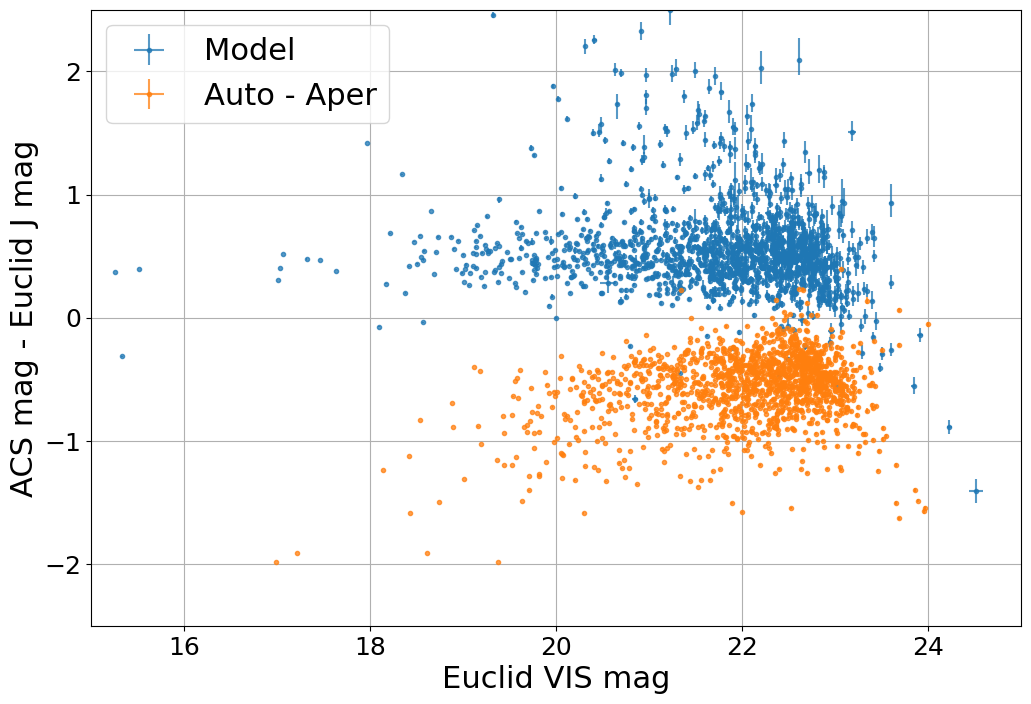

In [50]:
df_plot = df[(df.sep_zur < 1) & (df.FLUX_GIM2D > 0)]
print(df_plot.shape[0])

x0, x0_err = df_plot['MAG_VIS_SERSIC'].values, df_plot['MAGERR_VIS_SERSIC'].values
y0 = -2.5*np.log10(df_plot['FLUX_GIM2D'].values/3631) + 25.93
y0errm = (2.5/np.log(10))*((df_plot['LE_FLUX_GIM2D'].values)/df_plot['FLUX_GIM2D'].values)
y0errp = (2.5/np.log(10))*((df_plot['UE_FLUX_GIM2D'].values)/df_plot['FLUX_GIM2D'].values)

x1, x1_err = df_plot['MAG_VIS_APER'].values, df_plot['MAGERR_VIS_APER'].values
y1, y1_err = df_plot['ACS_MAG_AUTO'].values, df_plot['ACS_MAGERR_AUTO'].values

err_y0p = np.sqrt(x0_err*x0_err + y0errp*y0errp)
err_y0m = np.sqrt(x0_err*x0_err + y0errm*y0errm)
err_y1 = np.sqrt(x1_err*x1_err + y1_err*y1_err)

print(np.median(y0-x0))

keep1 = x1_err < 1000

#plt.scatter(x0, y0-x0, s=5, alpha=0.75, ls='', label='Model')
plt.errorbar(x0, y0-x0, xerr=x0_err, yerr=[err_y0m,err_y0p], marker='o', markersize=3, alpha=0.75, ls='', label='Model')
#plt.scatter(x1, y1-x1, s=5, alpha=0.75, label='Auto - Aper')
plt.errorbar(x1[keep1], y1[keep1]-x1[keep1], xerr=x1_err[keep1], yerr=err_y1[keep1], marker='o', markersize=3, alpha=0.75, ls='', label='Auto - Aper')

plt.xlim(15,25)
plt.ylim(-2.5,2.5)

plt.legend()
plt.xlabel('Euclid VIS mag')
plt.ylabel('ACS mag - Euclid J mag')
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_Zurich_photometry.png', format='png')
plt.show()

1527


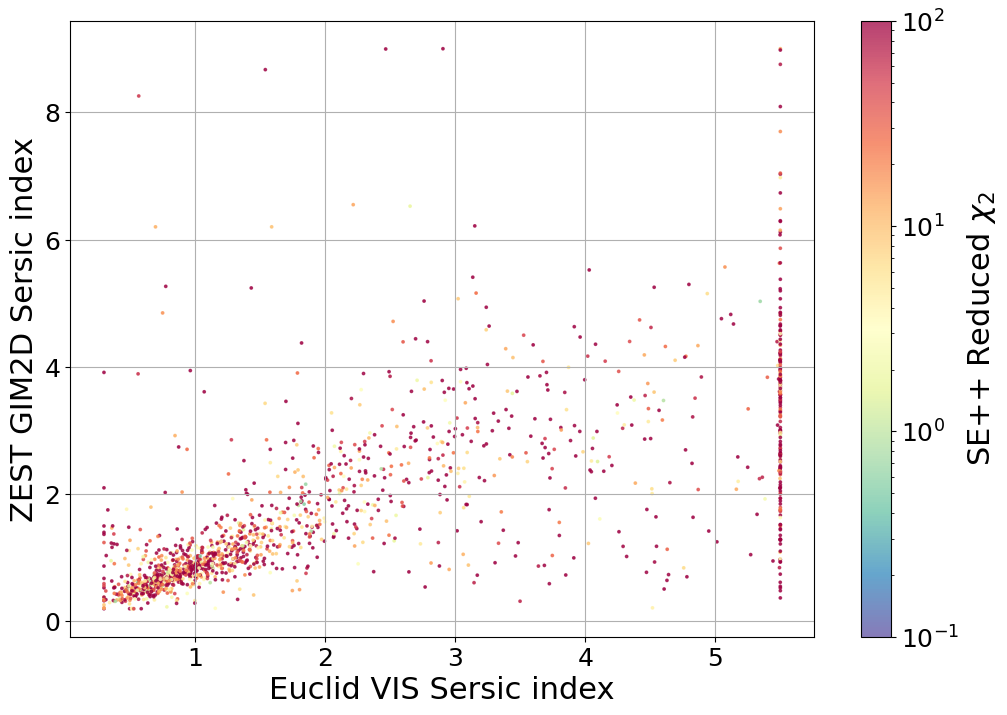

In [51]:
df_plot = df[(df.sep_zur < 1) & (df.SERSIC_N_GIM2D > 0)]
print(df_plot.shape[0])

x0, x0err = df_plot['SERSIC_SERSIC_INDEX'].values, df_plot['SERSIC_SERSIC_INDEX_ERR'].values
x1 = df_plot['SERSIC_N_GIM2D'].values
x1_le, x1_ue = df_plot['LE_N_GIM2D'].values, df_plot['UE_N_GIM2D'].values
z=df_plot['SERSIC_REDUCED_CHI2']


plt.scatter(x0, x1, s=3, alpha=0.75, ls='', c=z, cmap='Spectral_r', norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))
#plt.errorbar(x0, x1, xerr=x0err, yerr=[x1_le, x1_ue], markersize=2, alpha=0.5, ls='')

cbar = plt.colorbar()
cbar.set_label(r'SE++ Reduced $\chi_2$')

plt.xlabel('Euclid VIS Sersic index')
plt.ylabel('ZEST GIM2D Sersic index')
#plt.xlim(0,6)
#plt.ylim(0,6)
plt.grid()
plt.savefig('../Pictures/validation_fits_Cosmos_Euclid/compare_ZEST_Sersic_index.png', format='png')
plt.show()